
Author: Neel Barve

Date: February 2026

At1 version used mean reversion, price ratio and spread to generate trade signals.
In this attempt, I will be trying to
1. Create daily signals for future.
2. Complete backtesting
After succesful execution of these, will

## Part I: Generating Trading signals from rolling z-score of price ratios, for 6 cointegrated pairs selected from Large-cap energy sector

#### Importing Libraries and Data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS

# Top 15 large-cap energy stocks (as of recent data)
energy_tickers = [
    'COP',   # ConocoPhillips
    'EOG',   # EOG Resources
    'SLB',   # Schlumberger
    'MPC',   # Marathon Petroleum
    'PSX',   # Phillips 66
    'VLO',   # Valero Energy
    'OXY',   # Occidental Petroleum
    'HAL',   # Halliburton
    'DVN',   # Devon Energy
    'FANG',  # Diamondback Energy
    'BKR',   # Baker Hughes
    'APA',   # APA Corporation
    'CTRA',  # Coterra Energy
    'EQT',   # EQT Corporation
    'OVV',   # Ovintiv
]

#(5 years)
start_date = '2020-01-01'
end_date = '2024-12-31'

# Download data and select 'Close' prices
prices = yf.download(energy_tickers, start=start_date, end=end_date).xs('Close', level=0, axis=1)

# Clean data - remove any stocks with than 5% missing values
prices = prices.dropna(axis=1, thresh=len(prices)*0.95)
print(f"Stocks with sufficient data: {len(prices.columns)}")
print(prices.head())

/tmp/ipython-input-3576485448.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(energy_tickers, start=start_date, end=end_date).xs('Close', level=0, axis=1)
[*********************100%***********************]  15 of 15 completed

Stocks with sufficient data: 15
Ticker            APA        BKR        COP       CTRA        DVN        EOG  \
Date                                                                           
2020-01-02  21.878719  21.607765  52.563778  13.000110  18.737494  64.140327   
2020-01-03  22.163425  21.633076  52.756496  13.037831  18.962719  64.788277   
2020-01-06  22.120283  21.531834  53.382832  13.143464  19.187946  67.418213   
2020-01-07  28.047207  21.169031  53.382832  13.218918  19.246067  68.066208   
2020-01-08  28.237011  20.899035  52.146229  12.713398  18.563124  66.579697   

Ticker           EQT       FANG        HAL        MPC        OVV        OXY  \
Date                                                                          
2020-01-02  9.676202  72.399185  22.114538  51.348194  19.790342  38.862629   
2020-01-03  9.657522  73.774498  22.186216  48.295998  20.040850  39.802711   
2020-01-06  9.769602  74.157387  22.750732  48.287701  20.458370  41.116993   
2020-01-07  

#### Data cleaning

In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APA     1257 non-null   float64
 1   BKR     1257 non-null   float64
 2   COP     1257 non-null   float64
 3   CTRA    1257 non-null   float64
 4   DVN     1257 non-null   float64
 5   EOG     1257 non-null   float64
 6   EQT     1257 non-null   float64
 7   FANG    1257 non-null   float64
 8   HAL     1257 non-null   float64
 9   MPC     1257 non-null   float64
 10  OVV     1257 non-null   float64
 11  OXY     1257 non-null   float64
 12  PSX     1257 non-null   float64
 13  SLB     1257 non-null   float64
 14  VLO     1257 non-null   float64
dtypes: float64(15)
memory usage: 157.1 KB


In [ ]:
prices.isna().sum()

Ticker
APA     0
BKR     0
COP     0
CTRA    0
DVN     0
EOG     0
EQT     0
FANG    0
HAL     0
MPC     0
OVV     0
OXY     0
PSX     0
SLB     0
VLO     0
dtype: int64

In [ ]:
corr_matrix = prices.corr()
corr_matrix

Ticker       APA       BKR       COP      CTRA       DVN       EOG       EQT  \
Ticker                                                                         
APA     1.000000  0.708250  0.858890  0.805529  0.935161  0.855483  0.780345   
BKR     0.708250  1.000000  0.883115  0.811280  0.747445  0.920773  0.827750   
COP     0.858890  0.883115  1.000000  0.931682  0.906508  0.988033  0.911117   
CTRA    0.805529  0.811280  0.931682  1.000000  0.883894  0.914297  0.957067   
DVN     0.935161  0.747445  0.906508  0.883894  1.000000  0.908238  0.868841   
EOG     0.855483  0.920773  0.988033  0.914297  0.908238  1.000000  0.908610   
EQT     0.780345  0.827750  0.911117  0.957067  0.868841  0.908610  1.000000   
FANG    0.700763  0.910079  0.946239  0.860954  0.792537  0.953318  0.836516   
HAL     0.918125  0.876414  0.941331  0.866593  0.895252  0.937593  0.848494   
MPC     0.642914  0.865680  0.926395  0.842218  0.712475  0.909769  0.814284   
OVV     0.884518  0.852262  0.938309  0.891287  0.950849  0.947253  0.899495   
OXY     0.920696  0.809642  0.957220  0.914692  0.938629  0.948558  0.891806   
PSX     0.565863  0.834605  0.865967  0.760349  0.622246  0.856324  0.728641   
SLB     0.885483  0.859199  0.949688  0.836310  0.846502  0.938534  0.821528   
VLO     0.745883  0.874915  0.957019  0.890098  0.805625  0.949332  0.858000   

Ticker      FANG       HAL       MPC       OVV       OXY       PSX       SLB  \
Ticker                                                                         
APA     0.700763  0.918125  0.642914  0.884518  0.920696  0.565863  0.885483   
BKR     0.910079  0.876414  0.865680  0.852262  0.809642  0.834605  0.859199   
COP     0.946239  0.941331  0.926395  0.938309  0.957220  0.865967  0.949688   
CTRA    0.860954  0.866593  0.842218  0.891287  0.914692  0.760349  0.836310   
DVN     0.792537  0.895252  0.712475  0.950849  0.938629  0.622246  0.846502   
EOG     0.953318  0.937593  0.909769  0.947253  0.948558  0.856324  0.938534   
EQT     0.836516  0.848494  0.814284  0.899495  0.891806  0.728641  0.821528   
FANG    1.000000  0.862281  0.968138  0.884264  0.866719  0.942879  0.869655   
HAL     0.862281  1.000000  0.835786  0.936633  0.929189  0.779940  0.962492   
MPC     0.968138  0.835786  1.000000  0.812358  0.835544  0.972263  0.872104   
OVV     0.884264  0.936633  0.812358  1.000000  0.924654  0.749959  0.877868   
OXY     0.866719  0.929189  0.835544  0.924654  1.000000  0.768879  0.922919   
PSX     0.942879  0.779940  0.972263  0.749959  0.768879  1.000000  0.817386   
SLB     0.869655  0.962492  0.872104  0.877868  0.922919  0.817386  1.000000   
VLO     0.965626  0.886091  0.974390  0.870574  0.909463  0.945571  0.905074   

Ticker       VLO  
Ticker            
APA     0.745883  
BKR     0.874915  
COP     0.957019  
CTRA    0.890098  
DVN     0.805625  
EOG     0.949332  
EQT     0.858000  
FANG    0.965626  
HAL     0.886091  
MPC     0.974390  
OVV     0.870574  
OXY     0.909463  
PSX     0.945571  
SLB     0.905074  
VLO     1.000000

<Axes: xlabel='Ticker', ylabel='Ticker'>

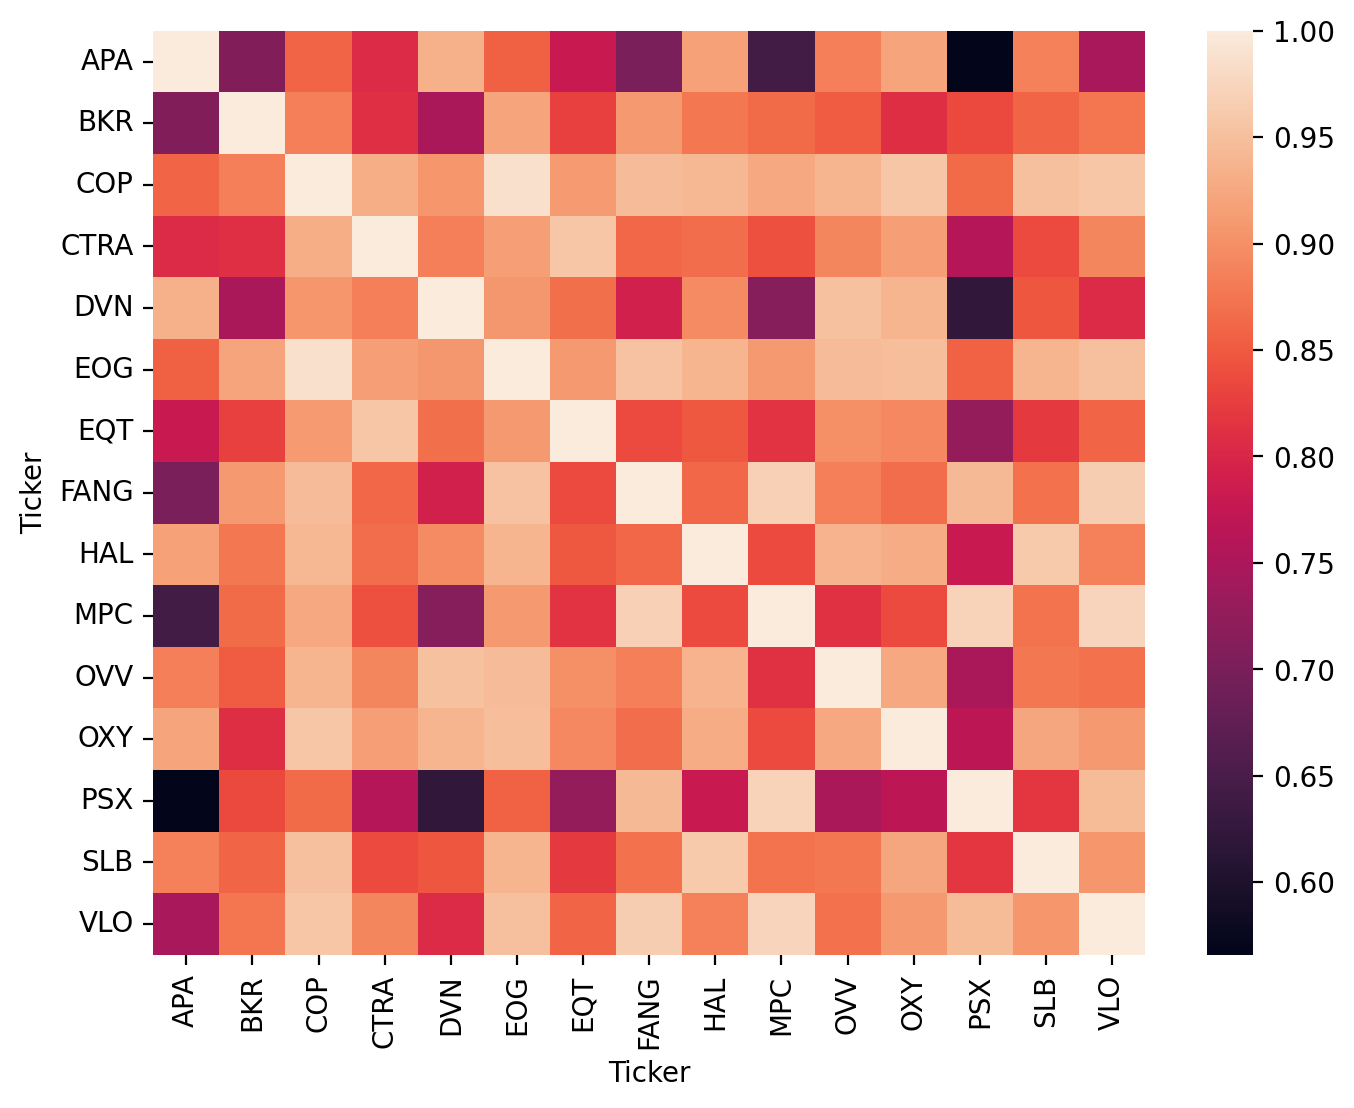

In [ ]:
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)
sn.heatmap(corr_matrix)

#### Stock pairs Identification

In [ ]:
# Generate all unique pairs
pairs_list = list(combinations(prices.columns, 2))
print(f"Total number of pairs to test: {len(pairs_list)}") # 15C2 = 15*7 = 105 pairs

Total number of pairs to test: 105


In [ ]:
import numpy as np

# Get the correlation matrix
corr_matrix = prices.corr()

# Create a list to store pairs and their correlations
correlated_pairs = []

# Iterate through the upper triangle of the correlation matrix (excluding self-correlation)
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        stock1 = corr_matrix.columns[i]
        stock2 = corr_matrix.columns[j]
        correlation = corr_matrix.iloc[i, j]
        correlated_pairs.append((correlation, f"{stock1}/{stock2}"))

# Sort the pairs by correlation in descending order
correlated_pairs.sort(key=lambda x: x[0], reverse=True)

print("\nCorrelated Pairs (correlation >= 0.4):")
# Print pairs with correlation >= 0.4
for corr, pair in correlated_pairs:
    if corr >= 0.4:
        print(f"  Pair: {pair}, Correlation: {corr:.4f}")


Correlated Pairs (correlation >= 0.4):
  Pair: COP/EOG, Correlation: 0.9880
  Pair: MPC/VLO, Correlation: 0.9744
  Pair: MPC/PSX, Correlation: 0.9723
  Pair: FANG/MPC, Correlation: 0.9681
  Pair: FANG/VLO, Correlation: 0.9656
  Pair: HAL/SLB, Correlation: 0.9625
  Pair: COP/OXY, Correlation: 0.9572
  Pair: CTRA/EQT, Correlation: 0.9571
  Pair: COP/VLO, Correlation: 0.9570
  Pair: EOG/FANG, Correlation: 0.9533
  Pair: DVN/OVV, Correlation: 0.9508
  Pair: COP/SLB, Correlation: 0.9497
  Pair: EOG/VLO, Correlation: 0.9493
  Pair: EOG/OXY, Correlation: 0.9486
  Pair: EOG/OVV, Correlation: 0.9473
  Pair: COP/FANG, Correlation: 0.9462
  Pair: PSX/VLO, Correlation: 0.9456
  Pair: FANG/PSX, Correlation: 0.9429
  Pair: COP/HAL, Correlation: 0.9413
  Pair: DVN/OXY, Correlation: 0.9386
  Pair: EOG/SLB, Correlation: 0.9385
  Pair: COP/OVV, Correlation: 0.9383
  Pair: EOG/HAL, Correlation: 0.9376
  Pair: HAL/OVV, Correlation: 0.9366
  Pair: APA/DVN, Correlation: 0.9352
  Pair: COP/CTRA, Correlation

In [ ]:
count_above_0_4 = sum(1 for corr, pair in correlated_pairs if corr >= 0.4)
print(f"Number of pairs with correlation >= 0.4: {count_above_0_4}")

Number of pairs with correlation >= 0.4: 105



Plotting prices for the top 5 highly correlated pairs...


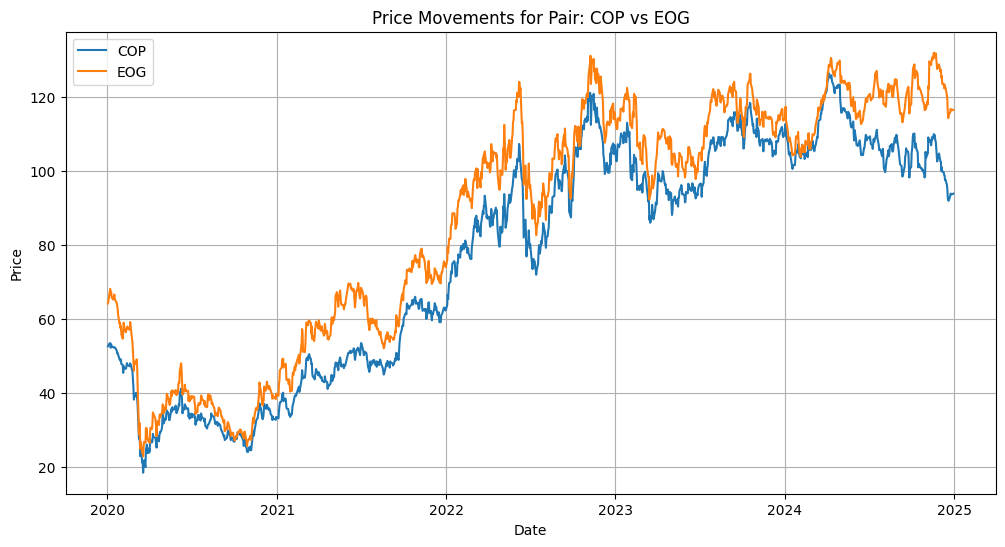

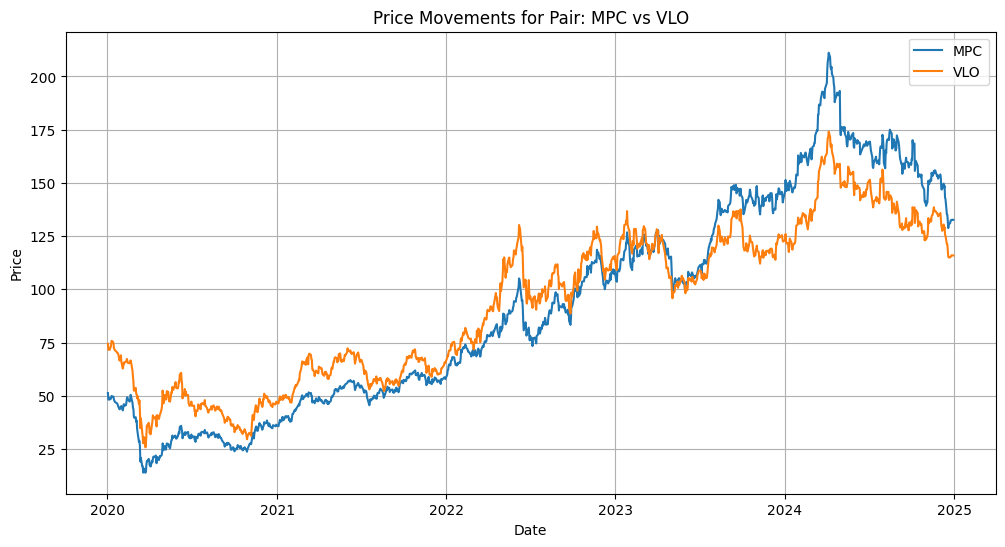

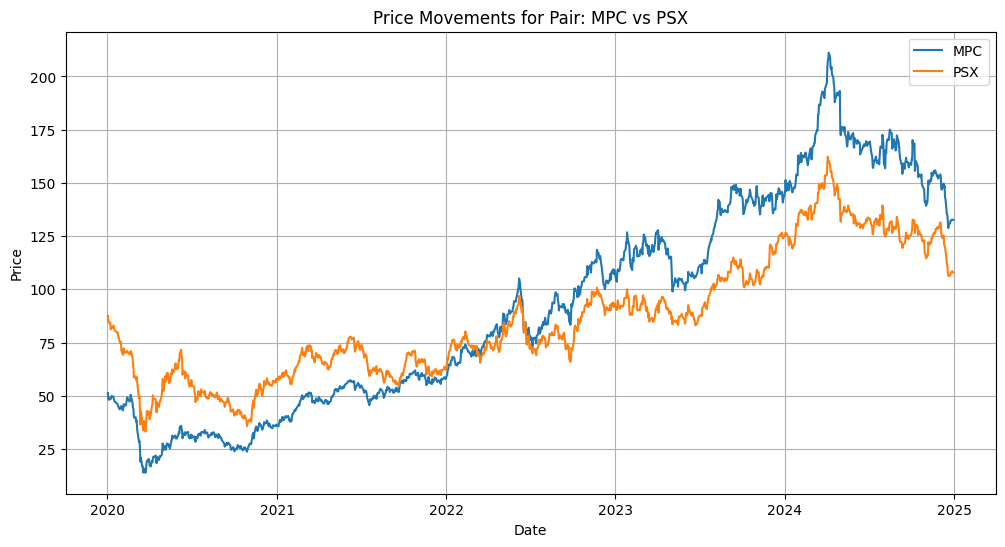

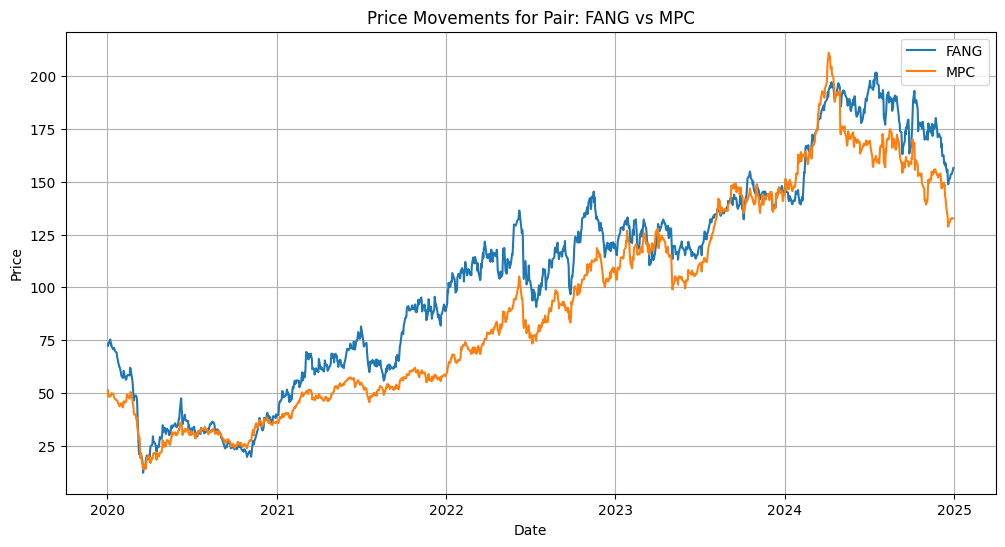

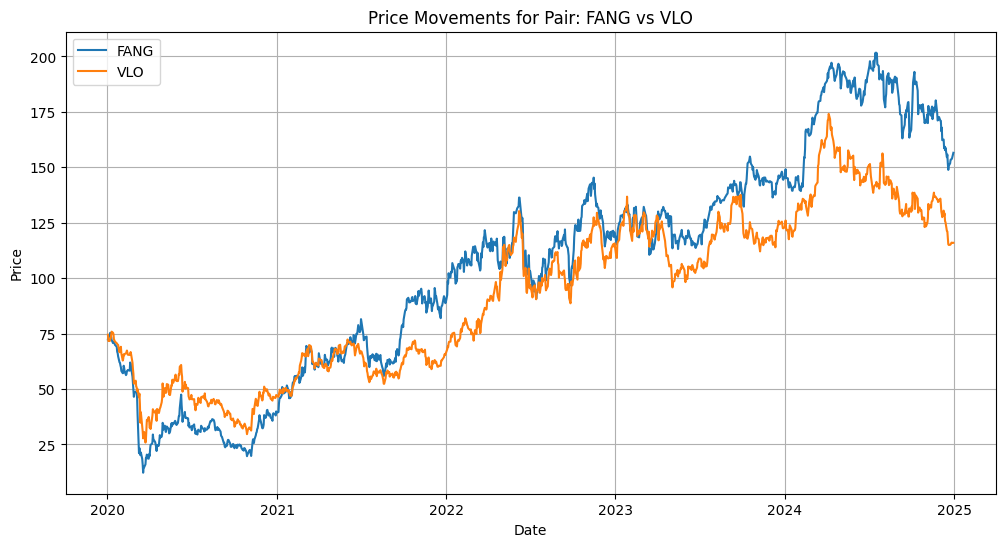

In [ ]:
import matplotlib.pyplot as plt

# Filter for pairs with correlation >= 0.7 and take the top 5 for plotting demonstration
plotting_pairs = [pair_data for corr, pair_data in correlated_pairs if corr >= 0.4][:5]

if not plotting_pairs:
    print("No highly correlated pairs (>= 0.4) found to plot.")
else:
    print(f"\nPlotting prices for the top {len(plotting_pairs)} highly correlated pairs...")
    for i, pair_string in enumerate(plotting_pairs):
        stock1, stock2 = pair_string.split('/')
        plt.figure(figsize=(12, 6))
        plt.plot(prices[stock1], label=stock1)
        plt.plot(prices[stock2], label=stock2)
        plt.title(f'Price Movements for Pair: {stock1} vs {stock2}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()


Plotting spreads for the top 2 correlated pairs (simple difference):


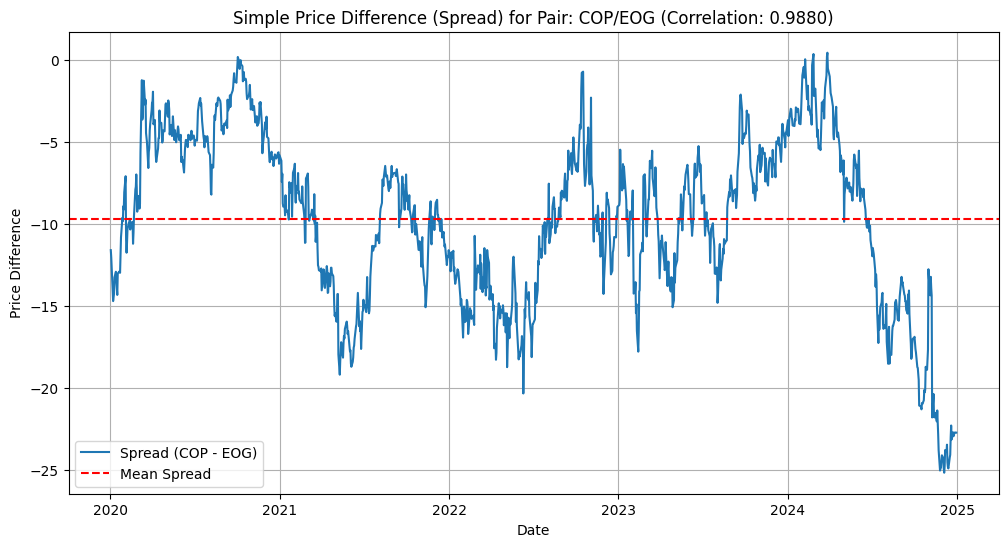

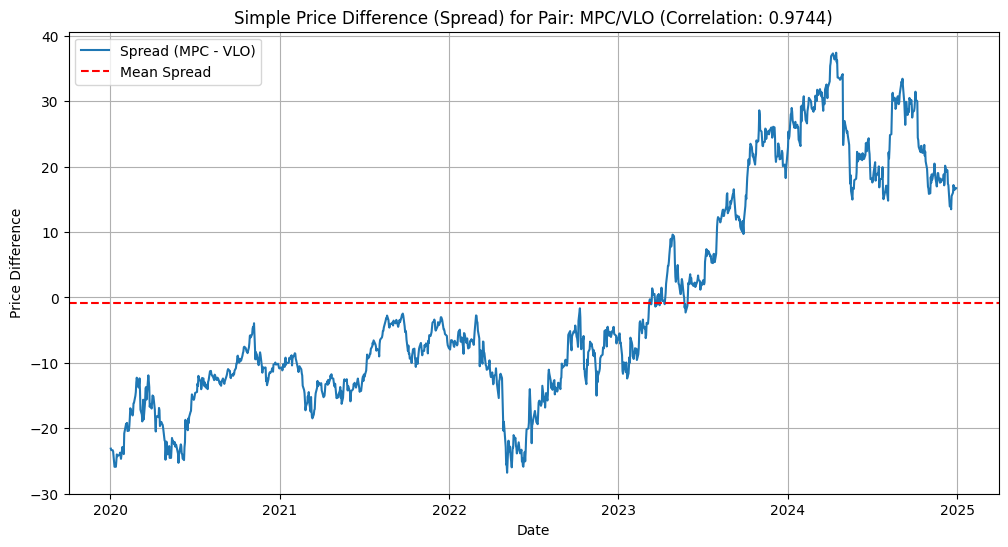

In [ ]:
import matplotlib.pyplot as plt

# Get the top 2 correlated pairs
top_2_correlated_pairs = correlated_pairs[:2]

if not top_2_correlated_pairs:
    print("No correlated pairs found to plot.")
else:
    print("\nPlotting spreads for the top 2 correlated pairs (simple difference):")
    for i, (correlation, pair_string) in enumerate(top_2_correlated_pairs):
        stock1, stock2 = pair_string.split('/')

        # Calculate the simple price difference (spread)
        # Ensure prices are aligned by date, dropping NaNs if any
        aligned_prices_for_spread = pd.DataFrame({
            stock1: prices[stock1],
            stock2: prices[stock2]
        }).dropna()

        spread_simple = aligned_prices_for_spread[stock1] - aligned_prices_for_spread[stock2]

        plt.figure(figsize=(12, 6))
        plt.plot(spread_simple, label=f'Spread ({stock1} - {stock2})')
        plt.axhline(spread_simple.mean(), color='red', linestyle='--', label='Mean Spread')
        plt.title(f'Simple Price Difference (Spread) for Pair: {pair_string} (Correlation: {correlation:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Price Difference')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Check stationarity

In [ ]:
import statsmodels.tsa.stattools as ts
#result_pair=
#result = ts.coint(BRK_B, MSFT)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, stock_name):
    """
    Performs Augmented Dickey-Fuller test on a time series.
    Returns p-value and a boolean indicating if the series is stationary (p-value < 0.05).
    """
    # Drop any NaNs before performing the test
    series = series.dropna()
    if len(series) < 5: # ADF test requires at least a few observations
        return stock_name, np.nan, False, "Not enough data points"

    try:
        adf_result = adfuller(series, maxlag=1)
        p_value = adf_result[1]
        is_stationary = p_value < 0.05
        return stock_name, p_value, is_stationary, None
    except Exception as e:
        return stock_name, np.nan, False, str(e)

# Run ADF test for each stock
stationarity_results = []
print("Running ADF tests for individual stocks...")
for stock_name in prices.columns:
    name, p_value, is_stationary, error = check_stationarity(prices[stock_name], stock_name)
    stationarity_results.append({
        'Stock': name,
        'ADF_P_Value': p_value,
        'Is_Stationary': is_stationary,
        'Error': error
    })

stationarity_df = pd.DataFrame(stationarity_results)

print("\n--- Individual Stock Stationarity (ADF Test) ---")
print(stationarity_df)

# Summarize I(0) vs I(1) candidates
i0_stocks = stationarity_df[stationarity_df['Is_Stationary'] == True]
i1_stocks = stationarity_df[stationarity_df['Is_Stationary'] == False]

print(f"\nNumber of I(0) (stationary) stocks: {len(i0_stocks)}")
if not i0_stocks.empty:
    print("I(0) Stocks:", i0_stocks['Stock'].tolist())

print(f"\nNumber of I(1) (non-stationary) stocks: {len(i1_stocks)}")
if not i1_stocks.empty:
    print("I(1) Stocks (potential cointegration candidates):", i1_stocks['Stock'].tolist())


Running ADF tests for individual stocks...

--- Individual Stock Stationarity (ADF Test) ---
   Stock  ADF_P_Value  Is_Stationary Error
0    APA     0.472865          False  None
1    BKR     0.844406          False  None
2    COP     0.727898          False  None
3   CTRA     0.406099          False  None
4    DVN     0.612434          False  None
5    EOG     0.738783          False  None
6    EQT     0.635047          False  None
7   FANG     0.829945          False  None
8    HAL     0.524965          False  None
9    MPC     0.834104          False  None
10   OVV     0.575509          False  None
11   OXY     0.692904          False  None
12   PSX     0.738108          False  None
13   SLB     0.631259          False  None
14   VLO     0.714107          False  None

Number of I(0) (stationary) stocks: 0

Number of I(1) (non-stationary) stocks: 15
I(1) Stocks (potential cointegration candidates): ['APA', 'BKR', 'COP', 'CTRA', 'DVN', 'EOG', 'EQT', 'FANG', 'HAL', 'MPC', 'OVV', 'OXY',

#### Conintegrated pairs

In [ ]:
coint_results = []

for stock1, stock2 in pairs_list:
    # Extract prices for the current pair
    series1 = prices[stock1]
    series2 = prices[stock2]

    # Align the two series and drop any NaNs
    aligned_series = pd.DataFrame({stock1: series1, stock2: series2}).dropna()

    if len(aligned_series) < 5:  # cointegration test needs sufficient data points
        # Skip if not enough data after dropping NaNs
        continue

    # Calculate the correlation between the prices
    current_correlation = aligned_series[stock1].corr(aligned_series[stock2])

    # Perform the Engle-Granger cointegration test
    try:
        coint_t, p_value, _ = coint(aligned_series[stock1], aligned_series[stock2])

        coint_results.append({
            'Pair': f"{stock1}/{stock2}",
            'Stock1': stock1,
            'Stock2': stock2,
            'Correlation': current_correlation,
            'Cointegration_P_Value': p_value
        })
    except Exception as e:
        print(f"Could not perform cointegration test for {stock1}/{stock2}: {e}")
        # Optionally store an error message or skip the pair
        coint_results.append({
            'Pair': f"{stock1}/{stock2}",
            'Stock1': stock1,
            'Stock2': stock2,
            'Correlation': current_correlation,
            'Cointegration_P_Value': np.nan, # Indicate test failed
            'Error': str(e)
        })

print(f"Generated {len(coint_results)} cointegration test results.")

Generated 105 cointegration test results.


**Reasoning**:
Now that the `coint_results` list is populated with cointegration test results for all pairs, I will convert this list into a Pandas DataFrame for easier analysis and display the pairs that show cointegration (p-value < 0.05).



In [ ]:
coint_df = pd.DataFrame(coint_results)

print("\n--- Cointegration Test Results ---")
print(coint_df.head())

# Filter for cointegrated pairs (p-value < 0.05)
cointegrated_pairs_df = coint_df[coint_df['Cointegration_P_Value'] < 0.05].sort_values(by='Cointegration_P_Value')

print("\n--- Cointegrated Pairs (P-Value < 0.05) ---")
if not cointegrated_pairs_df.empty:
    print(f"Found {len(cointegrated_pairs_df)} cointegrated pairs:")
    print(cointegrated_pairs_df)
else:
    print("No cointegrated pairs found with a P-Value less than 0.05.")


--- Cointegration Test Results ---
       Pair Stock1 Stock2  Correlation  Cointegration_P_Value
0   APA/BKR    APA    BKR     0.708250               0.874877
1   APA/COP    APA    COP     0.858890               0.604574
2  APA/CTRA    APA   CTRA     0.805529               0.395138
3   APA/DVN    APA    DVN     0.935161               0.051719
4   APA/EOG    APA    EOG     0.855483               0.777572

--- Cointegrated Pairs (P-Value < 0.05) ---
Found 6 cointegrated pairs:
        Pair Stock1 Stock2  Correlation  Cointegration_P_Value
92   MPC/PSX    MPC    PSX     0.972263               0.003247
73   EQT/OXY    EQT    OXY     0.891806               0.008381
46  CTRA/OXY   CTRA    OXY     0.914692               0.017460
41  CTRA/EQT   CTRA    EQT     0.957067               0.035400
83  FANG/VLO   FANG    VLO     0.965626               0.037289
49  CTRA/VLO   CTRA    VLO     0.890098               0.047851


#### Cointegrated pairs visualization


Plotting Price Ratios for Cointegrated Pairs...


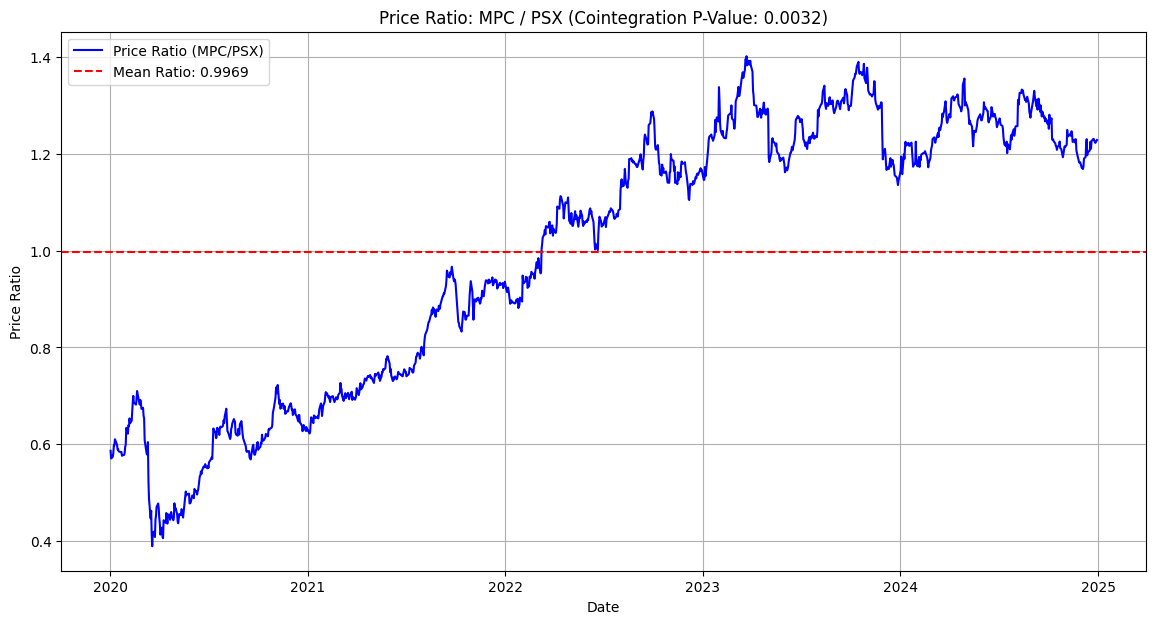

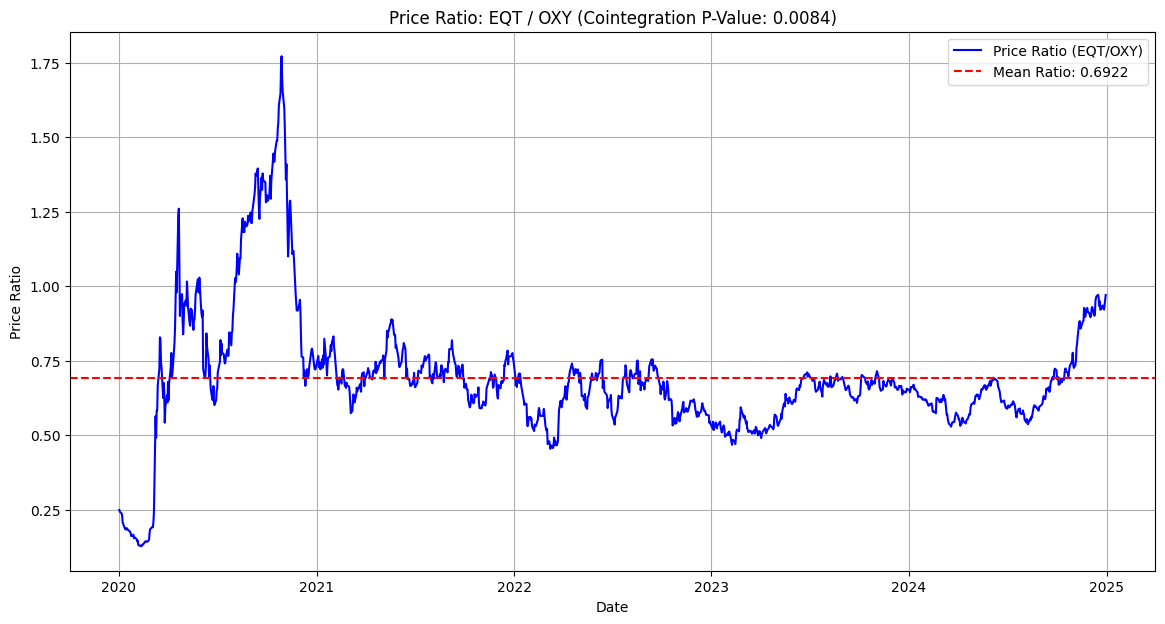

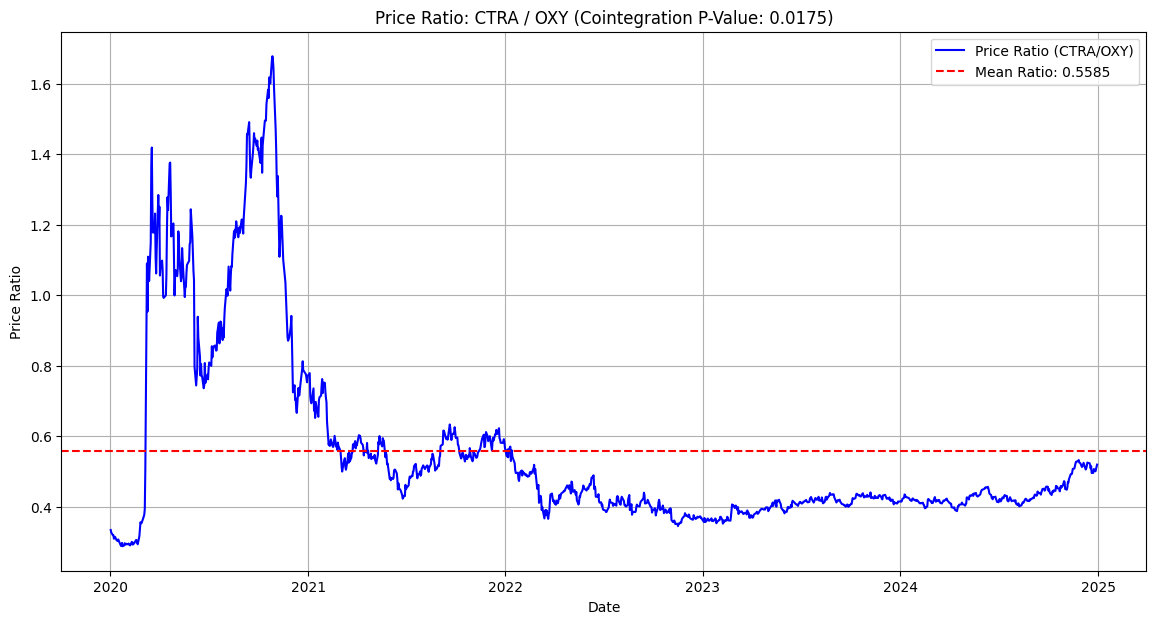

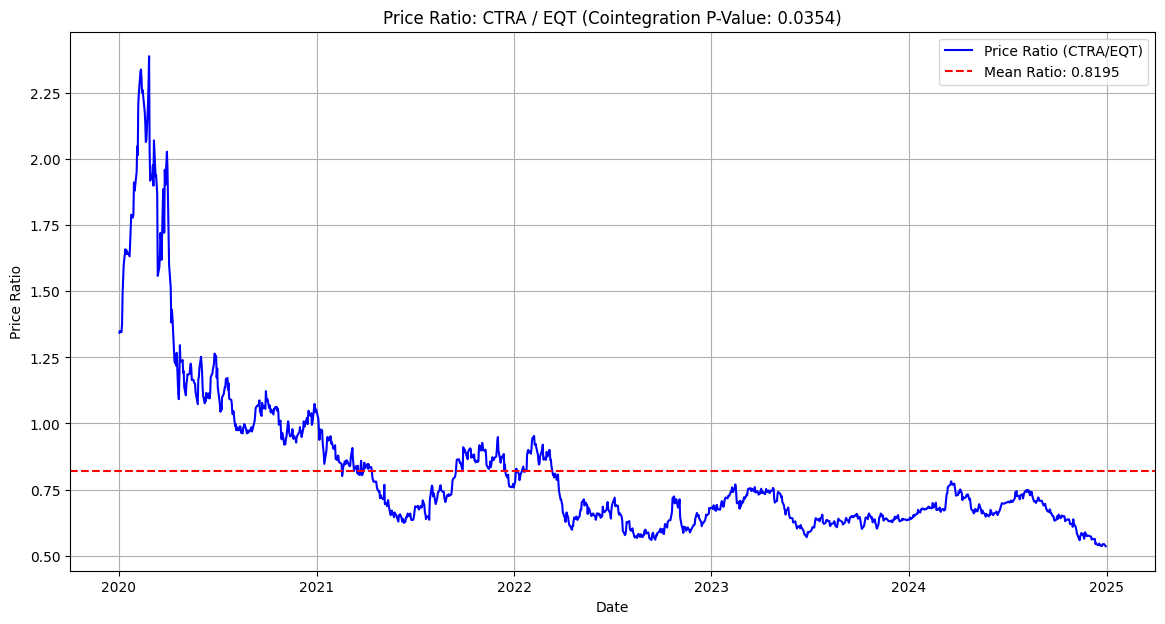

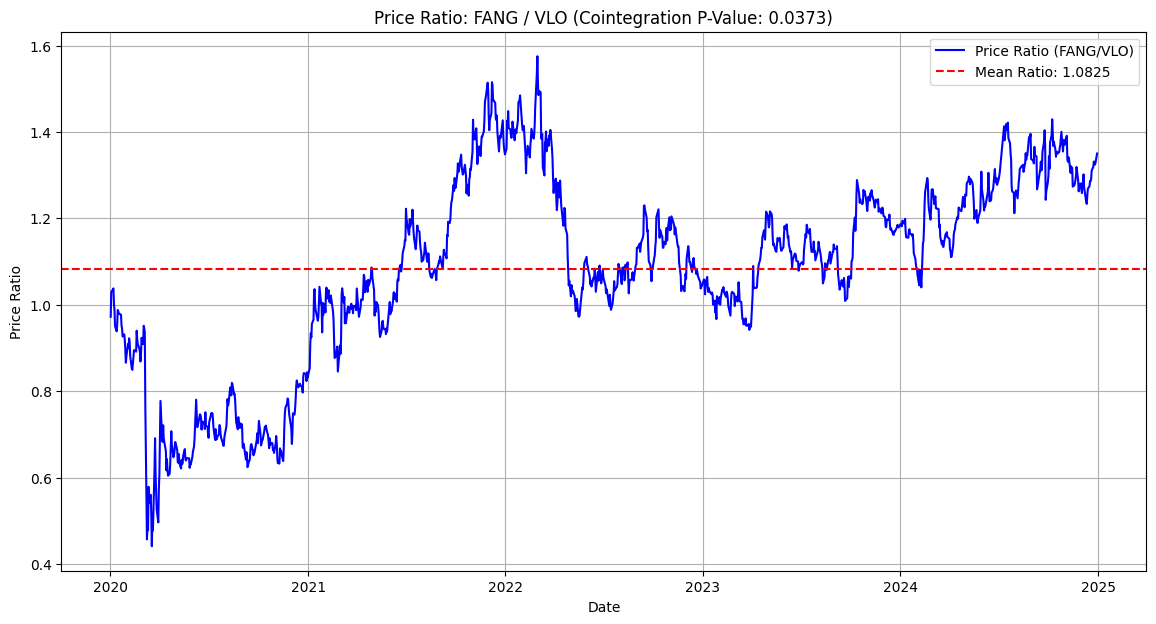

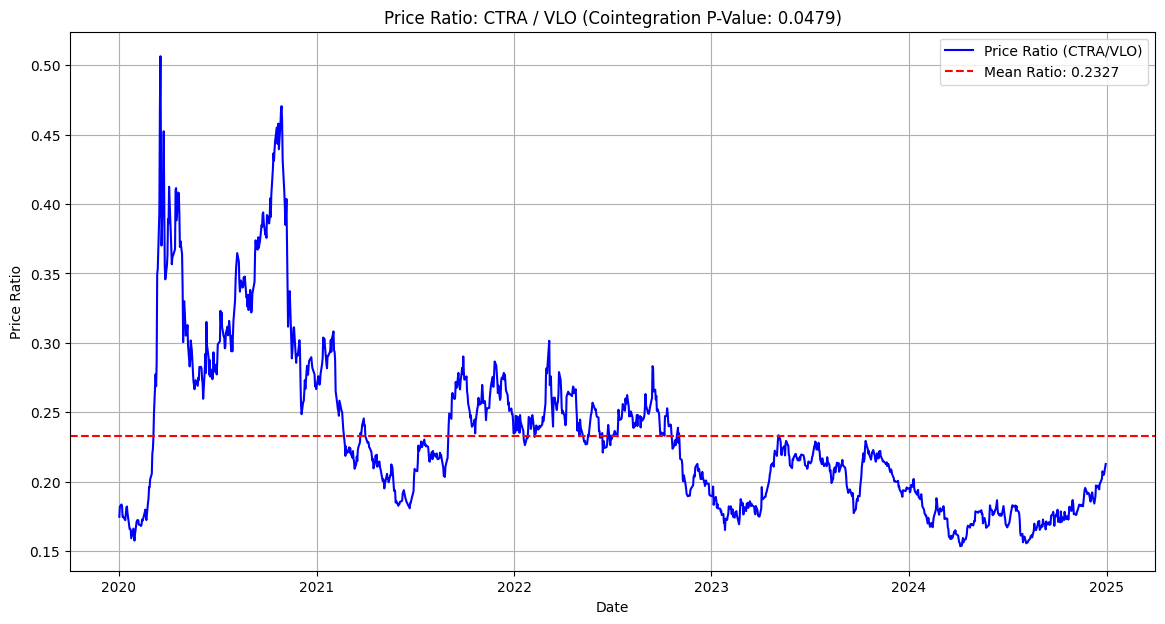

In [ ]:
import matplotlib.pyplot as plt

print("\nPlotting Price Ratios for Cointegrated Pairs...")

if cointegrated_pairs_df.empty:
    print("No cointegrated pairs to plot ratios for.")
else:
    for index, row in cointegrated_pairs_df.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']

        # Calculate the price ratio and drop NaNs
        # Ensure prices are aligned by date implicitly by pandas division
        price_ratio = (prices[stock1] / prices[stock2]).dropna()

        if price_ratio.empty:
            print(f"Skipping plotting for pair {stock1}/{stock2} due to empty price ratio after dropping NaNs.")
            continue

        mean_ratio = price_ratio.mean()

        plt.figure(figsize=(14, 7))
        plt.plot(price_ratio, label=f'Price Ratio ({stock1}/{stock2})', color='blue')
        plt.axhline(mean_ratio, color='red', linestyle='--', label=f'Mean Ratio: {mean_ratio:.4f}')
        plt.title(f'Price Ratio: {stock1} / {stock2} (Cointegration P-Value: {row["Cointegration_P_Value"]:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Price Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Spread visualization for cointgrated pairs


Calculating and Plotting Spreads for Cointegrated Pairs...


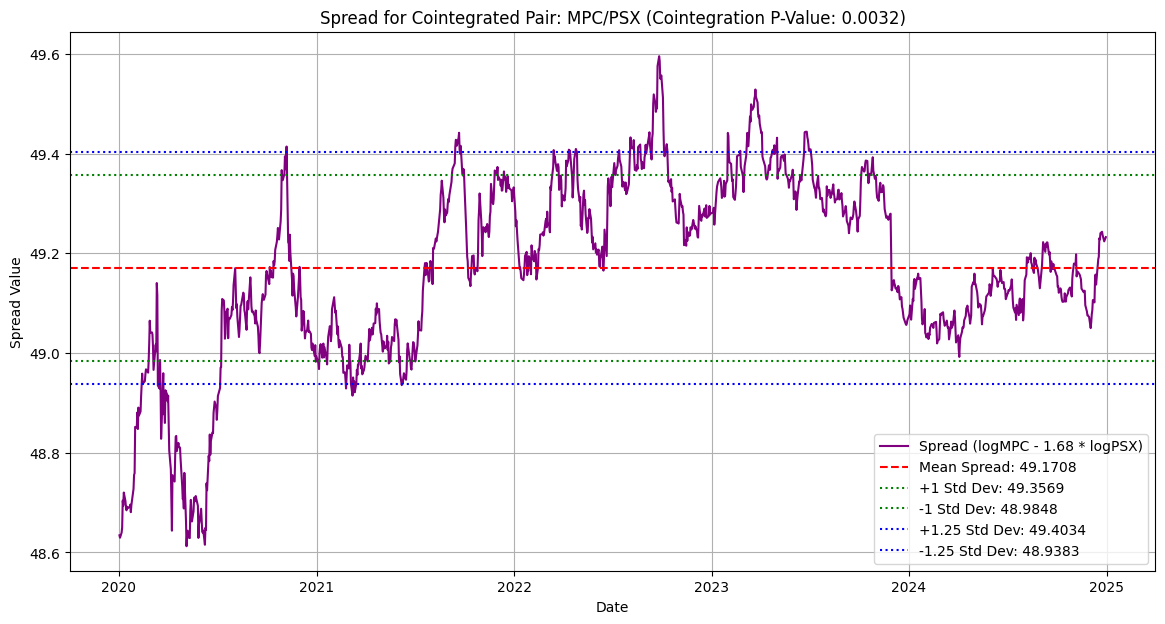

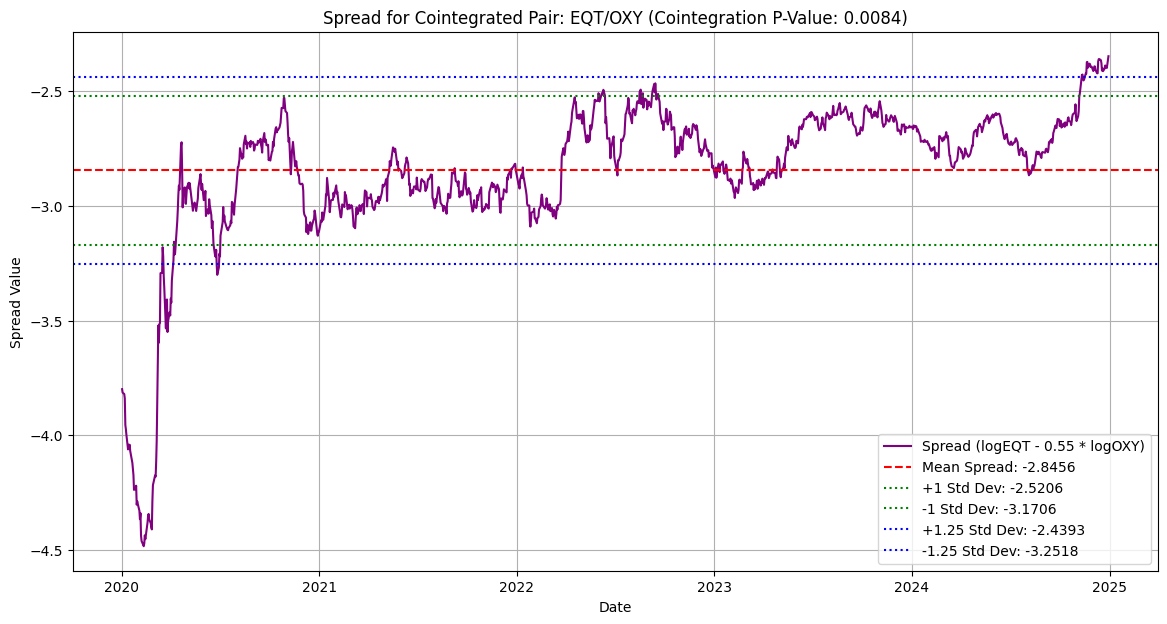

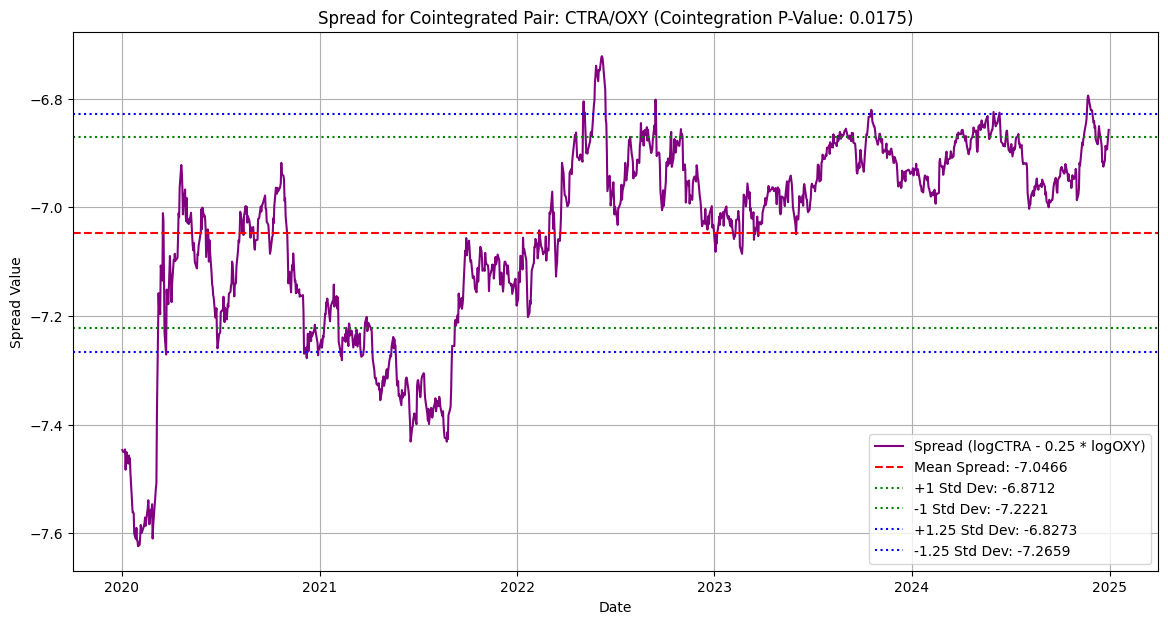

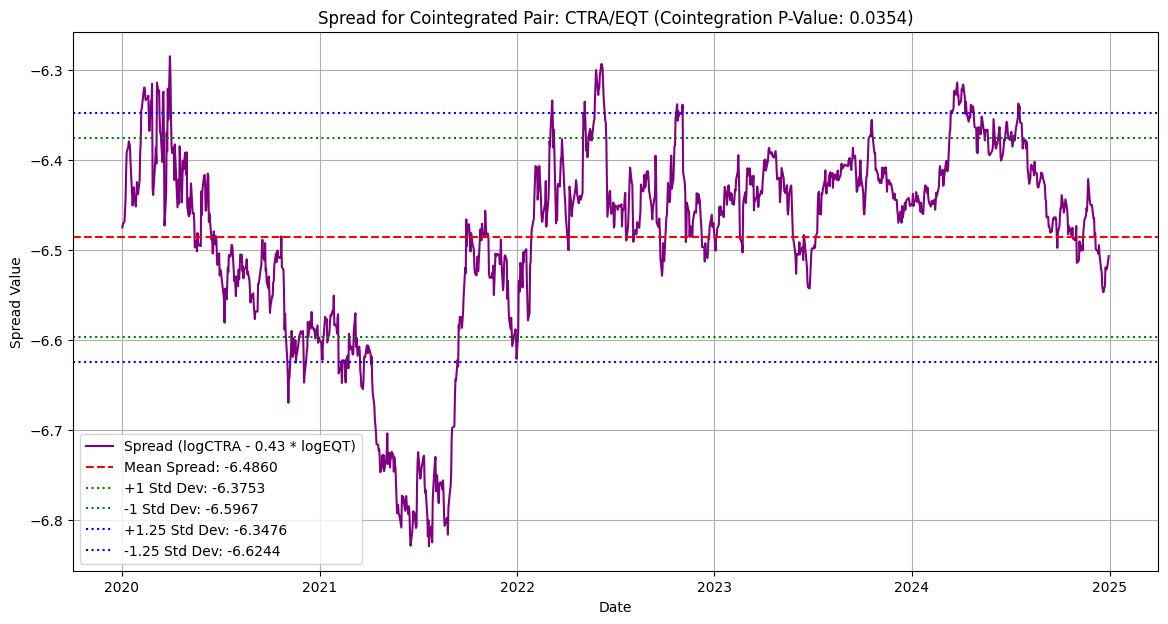

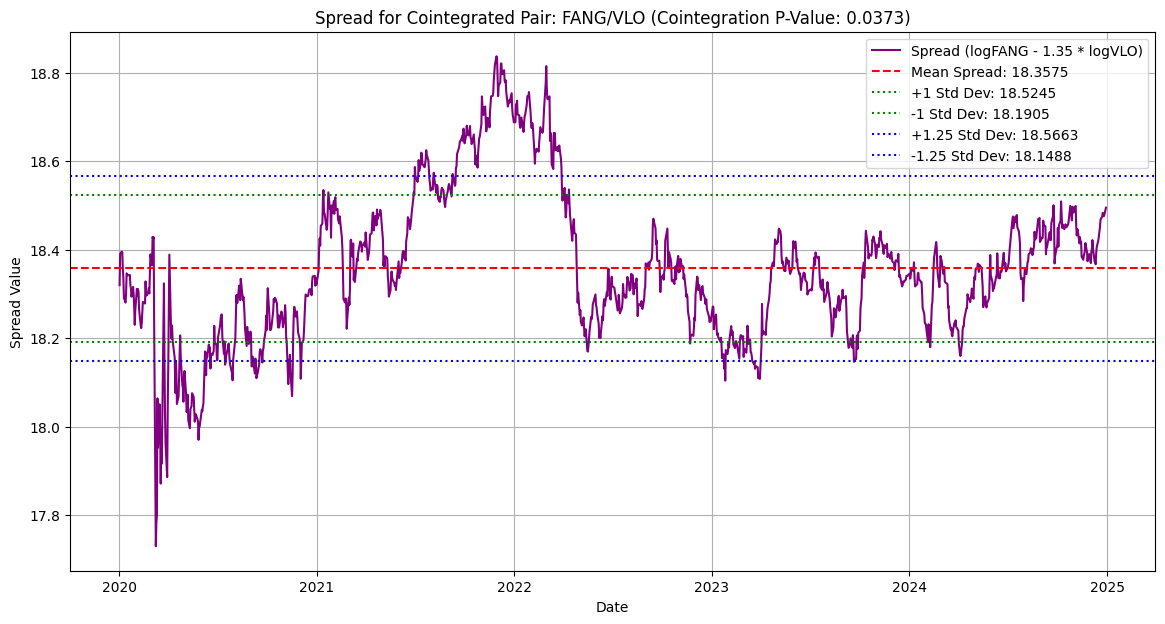

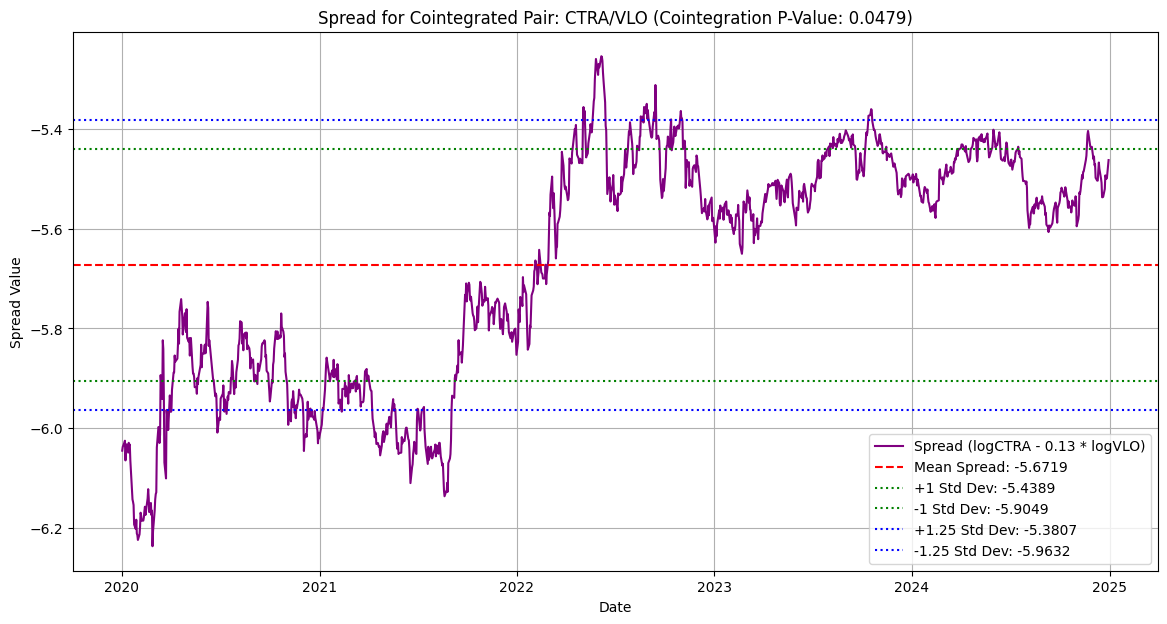

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("\nCalculating and Plotting Spreads for Cointegrated Pairs...")

if cointegrated_pairs_df.empty:
    print("No cointegrated pairs to calculate spreads for.")
else:
    for index, row in cointegrated_pairs_df.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']

        # 1. Align the data for the selected pair
        aligned_data = pd.DataFrame({
            stock1: prices[stock1],
            stock2: prices[stock2]
        }).dropna()

        if len(aligned_data) < 5:
            print(f"Skipping spread calculation for pair {stock1}/{stock2} due to insufficient data after alignment.")
            continue

        # 2. Perform OLS regression to find the hedge ratio and intercept
        # Regress Stock1 on Stock2
        try:
            model = sm.OLS(aligned_data[stock1], sm.add_constant(aligned_data[stock2])).fit()
            hedge_ratio = model.params[stock2] # Coefficient of stock2
            intercept = model.params['const']
        except Exception as e:
            print(f"Could not perform OLS regression for {stock1}/{stock2}: {e}")
            continue

        # 3. Calculate the spread (residuals)
        # Spread = Stock1 - (Hedge Ratio * Stock2) - Intercept
        spread = np.log(aligned_data[stock1]) - (hedge_ratio * np.log(aligned_data[stock2])) - intercept

        # 4. Plot the spread
        mean_spread = spread.mean()
        std_spread = spread.std()

        plt.figure(figsize=(14, 7))
        plt.plot(spread, label=f'Spread (log{stock1} - {hedge_ratio:.2f} * log{stock2})', color='purple')
        plt.axhline(mean_spread, color='red', linestyle='--', label=f'Mean Spread: {mean_spread:.4f}')
        plt.axhline(mean_spread + std_spread, color='green', linestyle=':', label=f'+1 Std Dev: {(mean_spread + std_spread):.4f}')
        plt.axhline(mean_spread - std_spread, color='green', linestyle=':', label=f'-1 Std Dev: {(mean_spread - std_spread):.4f}')

        plt.axhline(mean_spread + 1.25*std_spread, color='blue', linestyle=':', label=f'+1.25 Std Dev: {(mean_spread + 1.25*std_spread):.4f}')
        plt.axhline(mean_spread - 1.25*std_spread, color='blue', linestyle=':', label=f'-1.25 Std Dev: {(mean_spread - 1.25*std_spread):.4f}')

        plt.title(f'Spread for Cointegrated Pair: {stock1}/{stock2} (Cointegration P-Value: {row["Cointegration_P_Value"]:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Spread Value')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Z score for spread


Calculating Z-Scores for Spreads and Plotting...


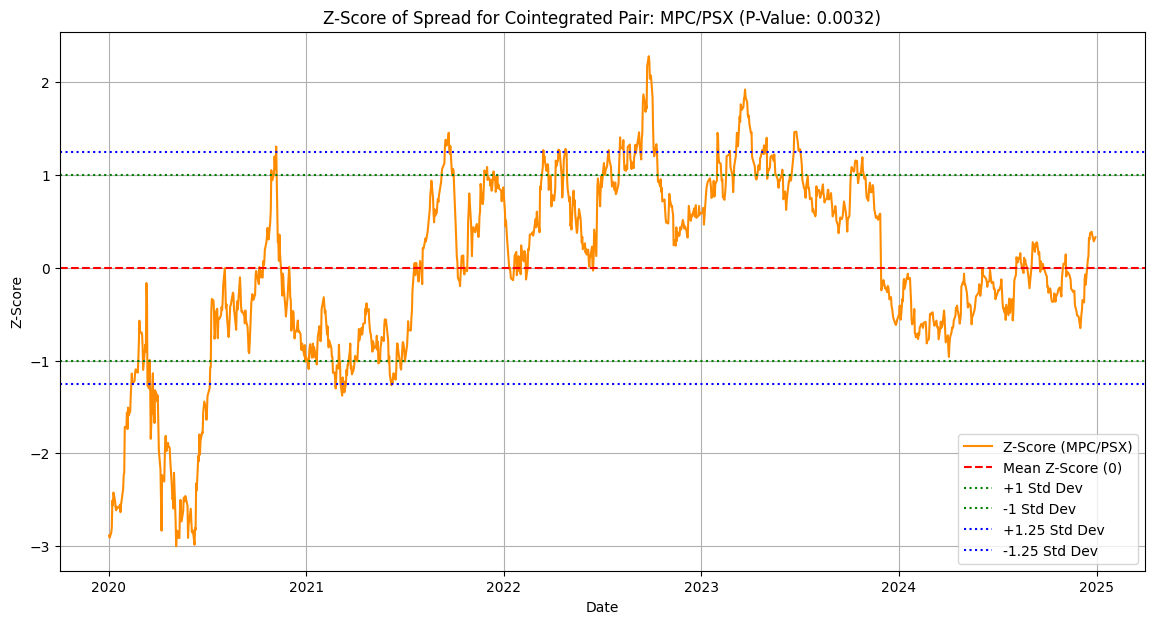

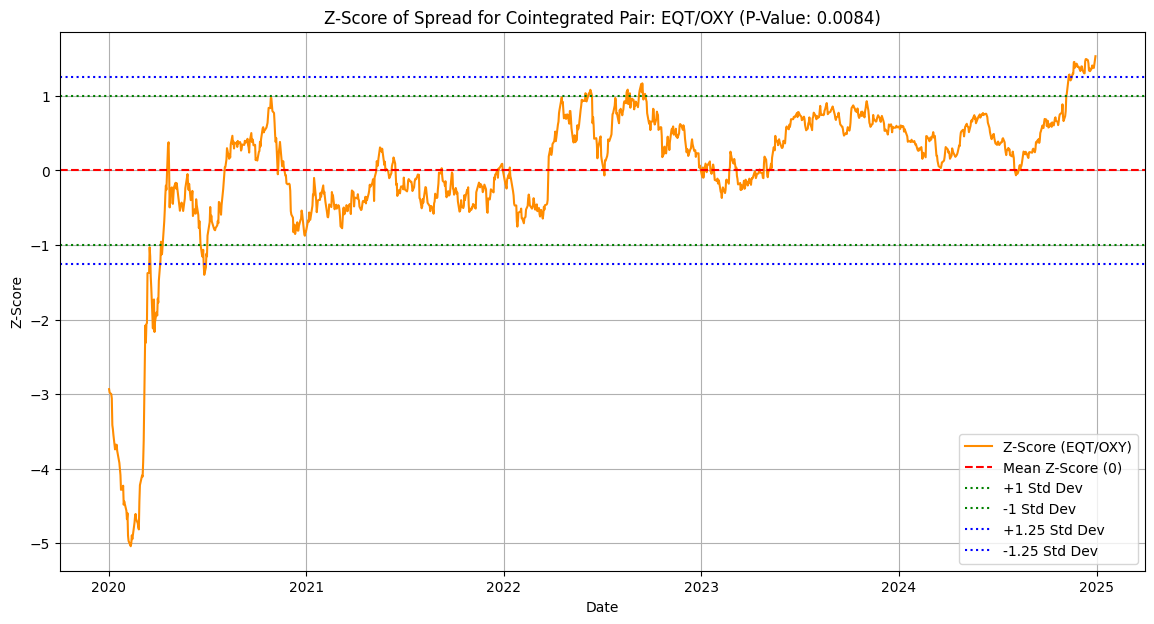

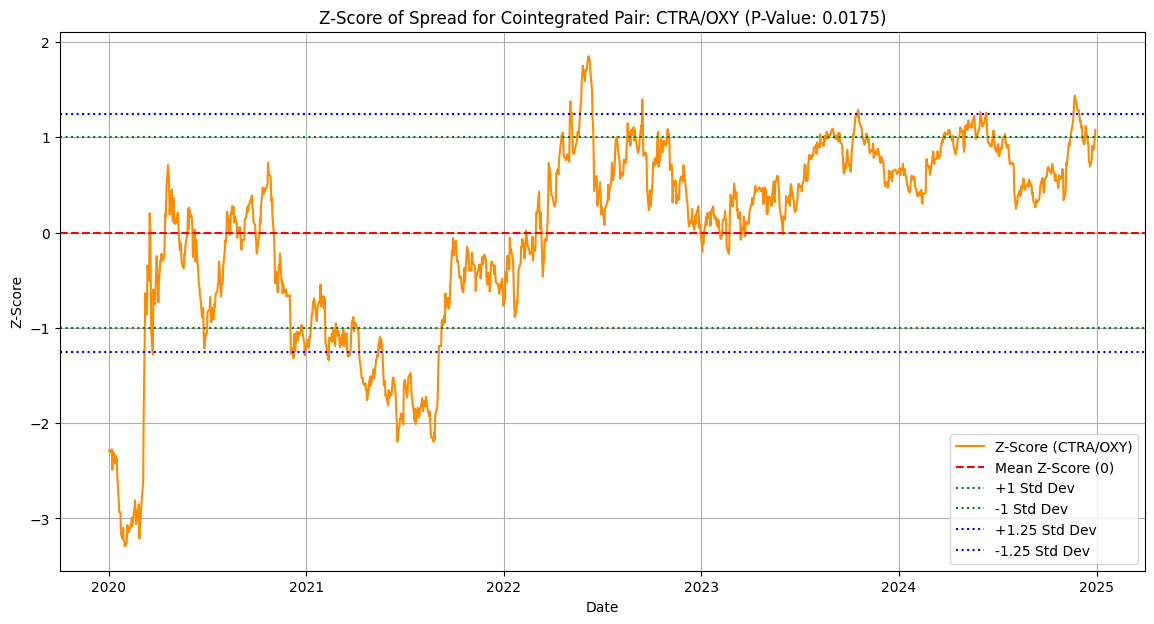

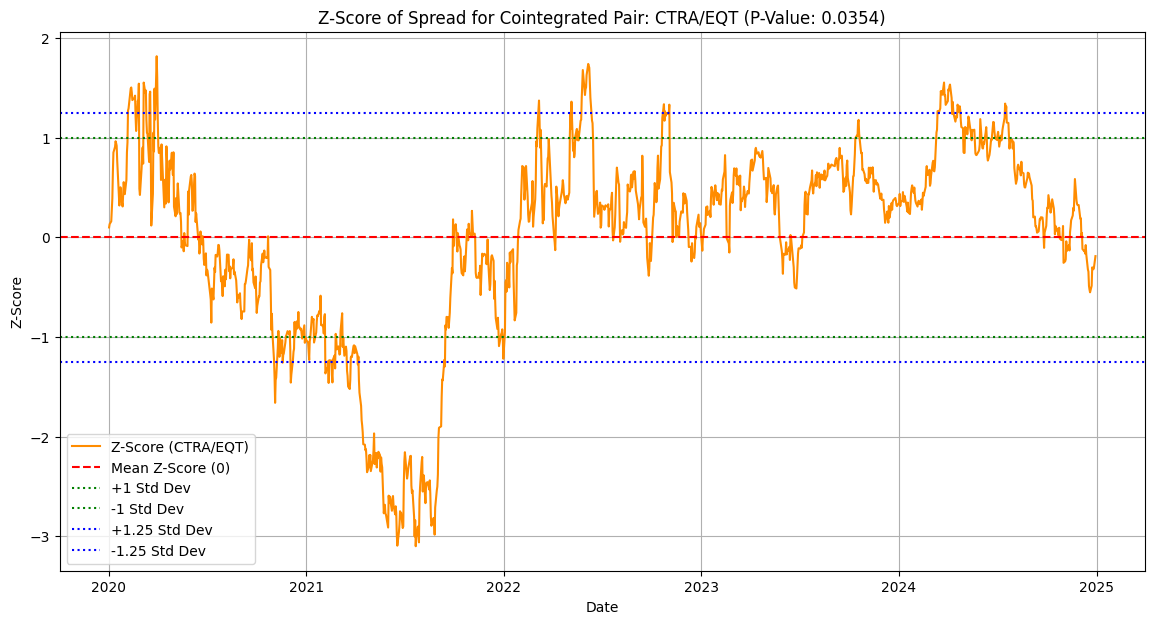

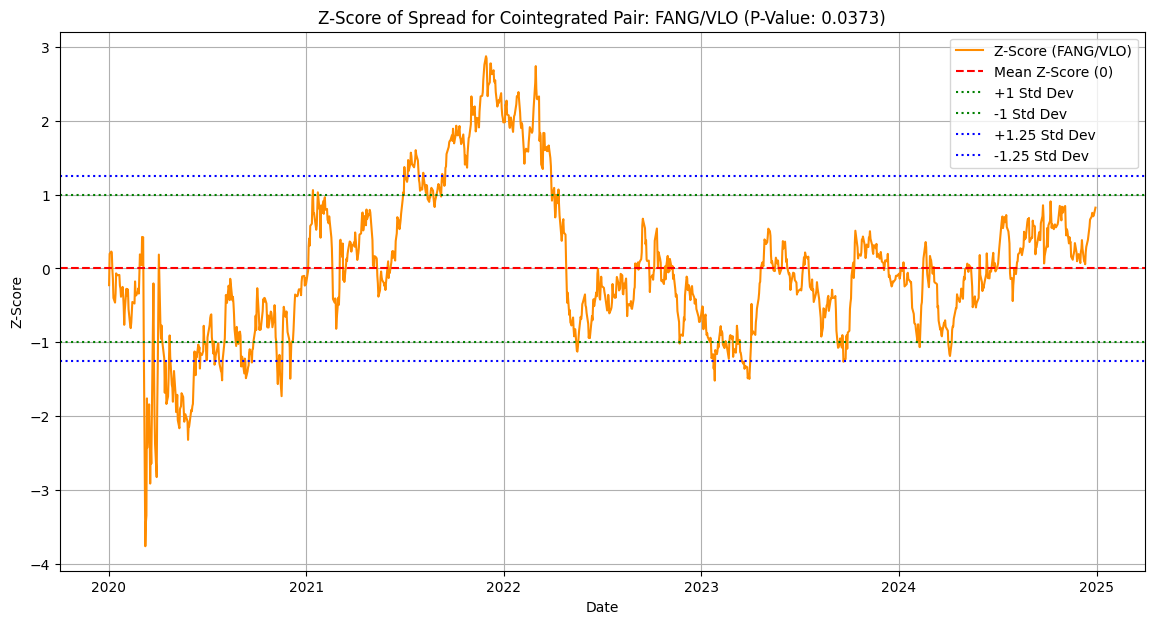

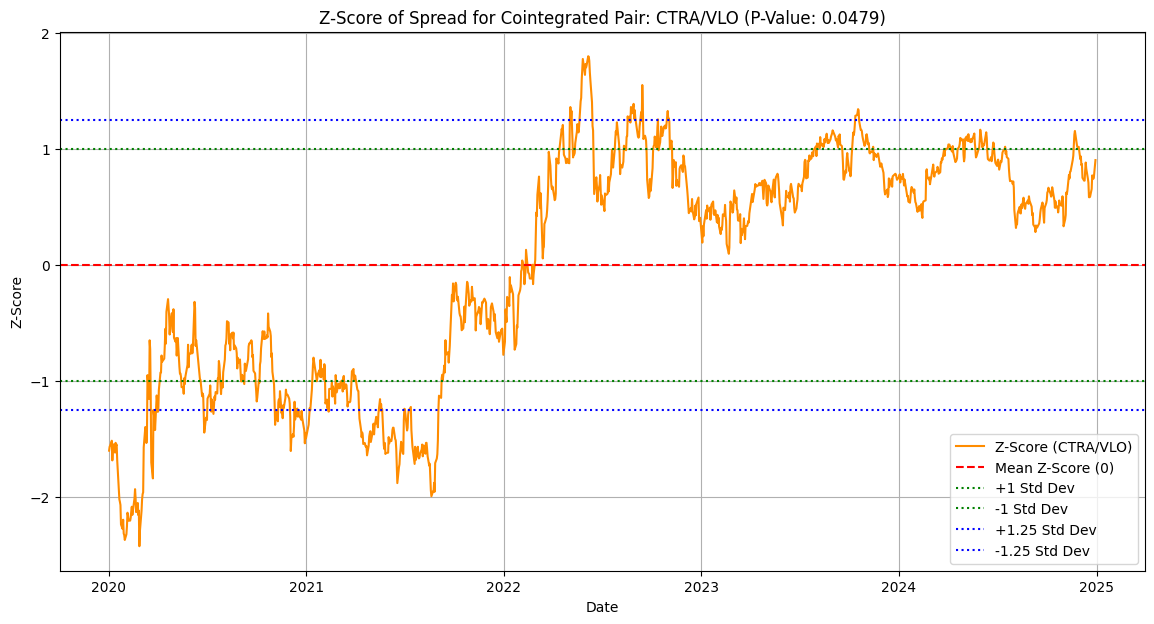

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("\nCalculating Z-Scores for Spreads and Plotting...")

if cointegrated_pairs_df.empty:
    print("No cointegrated pairs to calculate Z-scores for.")
else:
    for index, row in cointegrated_pairs_df.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']

        # 1. Align the data for the selected pair
        aligned_data = pd.DataFrame({
            stock1: prices[stock1],
            stock2: prices[stock2]
        }).dropna()

        if len(aligned_data) < 5:
            print(f"Skipping Z-score calculation for pair {stock1}/{stock2} due to insufficient data after alignment.")
            continue

        # 2. Perform OLS regression to find the hedge ratio and intercept
        try:
            model = sm.OLS(aligned_data[stock1], sm.add_constant(aligned_data[stock2])).fit()
            hedge_ratio = model.params[stock2]
            intercept = model.params['const']
        except Exception as e:
            print(f"Could not perform OLS regression for {stock1}/{stock2}: {e}")
            continue

        # 3. Calculate the spread (residuals)
        spread = np.log(aligned_data[stock1]) - (hedge_ratio * np.log(aligned_data[stock2])) - intercept

        # 4. Calculate the Z-score of the spread
        if spread.std() == 0:
            z_score = pd.Series(0, index=spread.index) # Avoid division by zero
        else:
            z_score = (spread - spread.mean()) / spread.std()

        # 5. Plot the Z-score
        plt.figure(figsize=(14, 7))
        plt.plot(z_score, label=f'Z-Score ({stock1}/{stock2})', color='darkorange')
        plt.axhline(0, color='red', linestyle='--', label='Mean Z-Score (0)')
        plt.axhline(1, color='green', linestyle=':', label='+1 Std Dev')
        plt.axhline(-1, color='green', linestyle=':', label='-1 Std Dev')
        plt.axhline(1.25, color='blue', linestyle=':', label='+1.25 Std Dev')
        plt.axhline(-1.25, color='blue', linestyle=':', label='-1.25 Std Dev')

        plt.title(f'Z-Score of Spread for Cointegrated Pair: {stock1}/{stock2} (P-Value: {row["Cointegration_P_Value"]:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Z-Score')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Moving average


Calculating and Plotting Moving Average Ratios for Cointegrated Pairs...


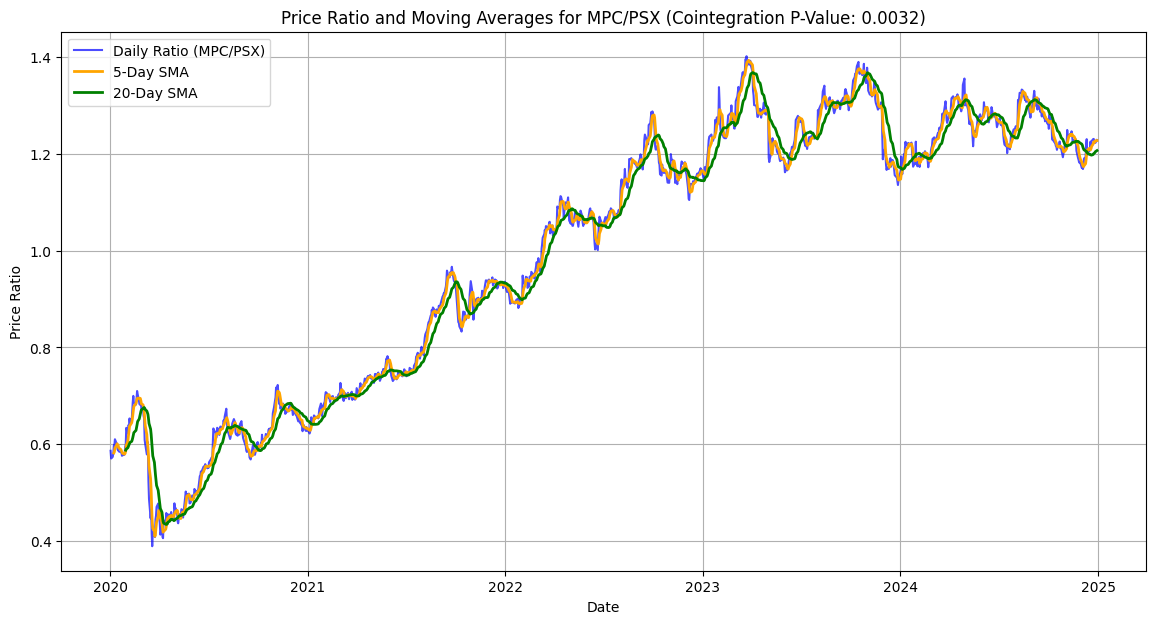

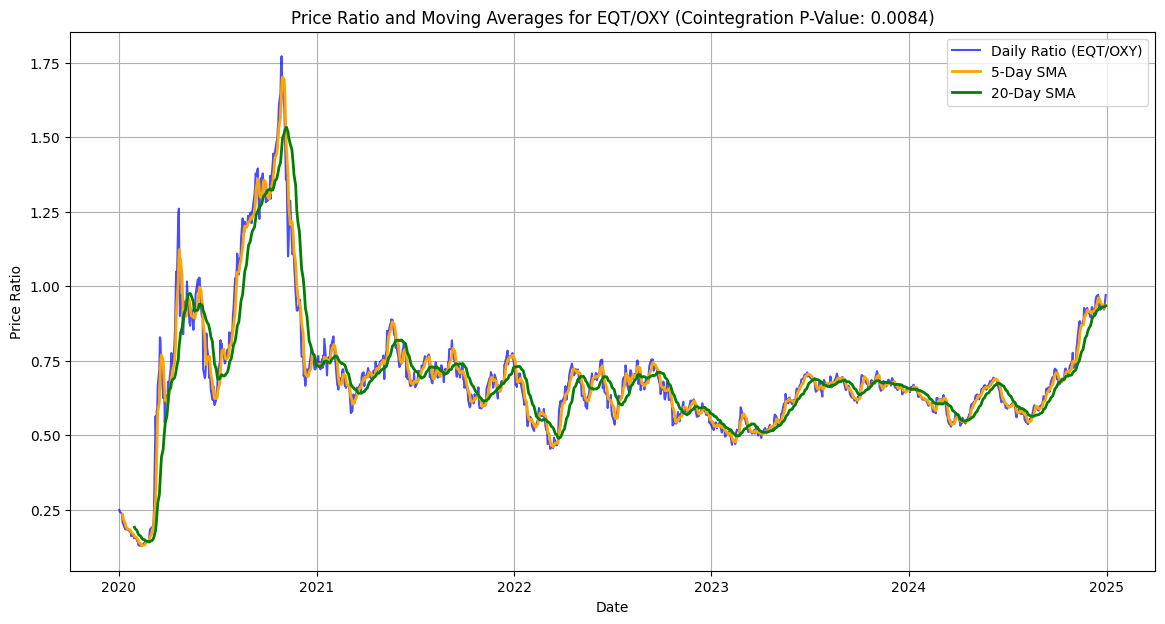

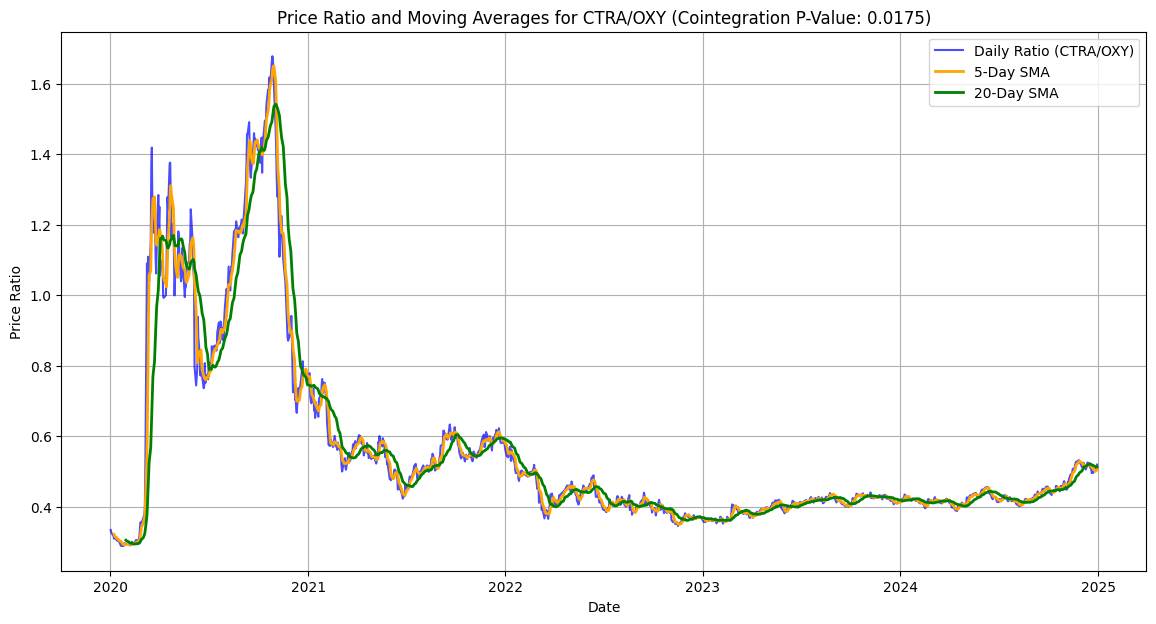

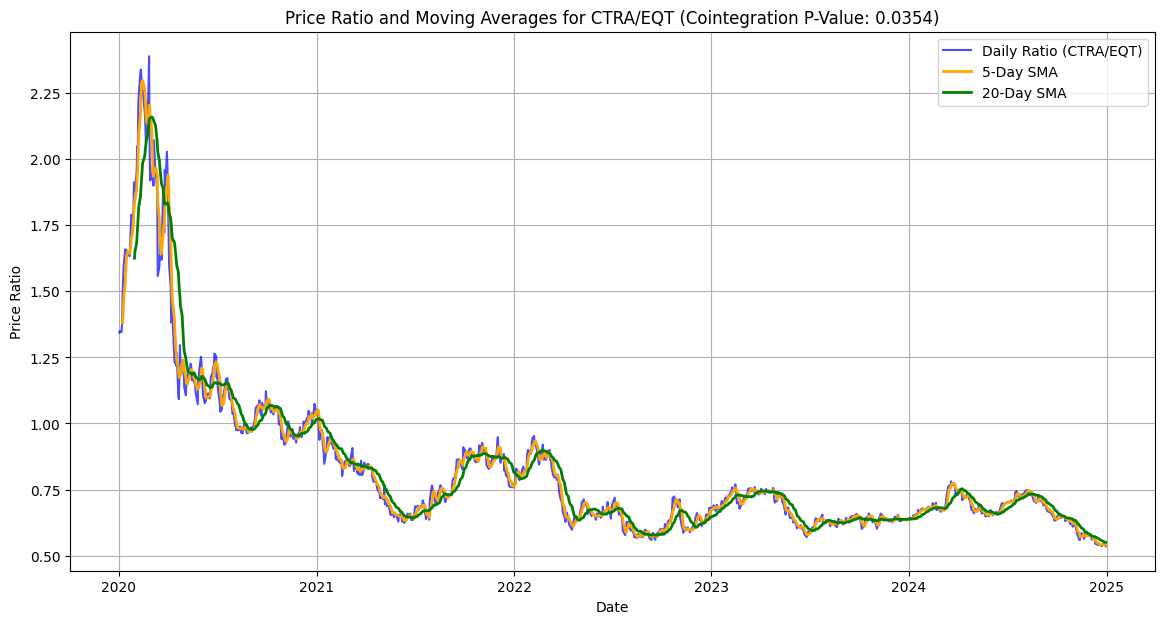

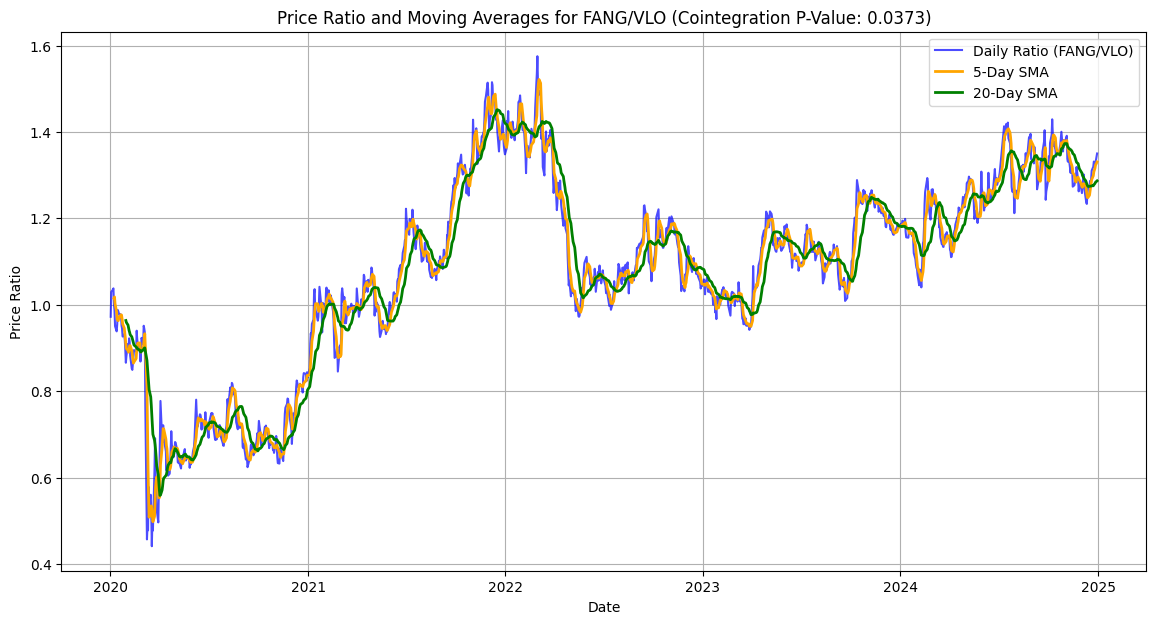

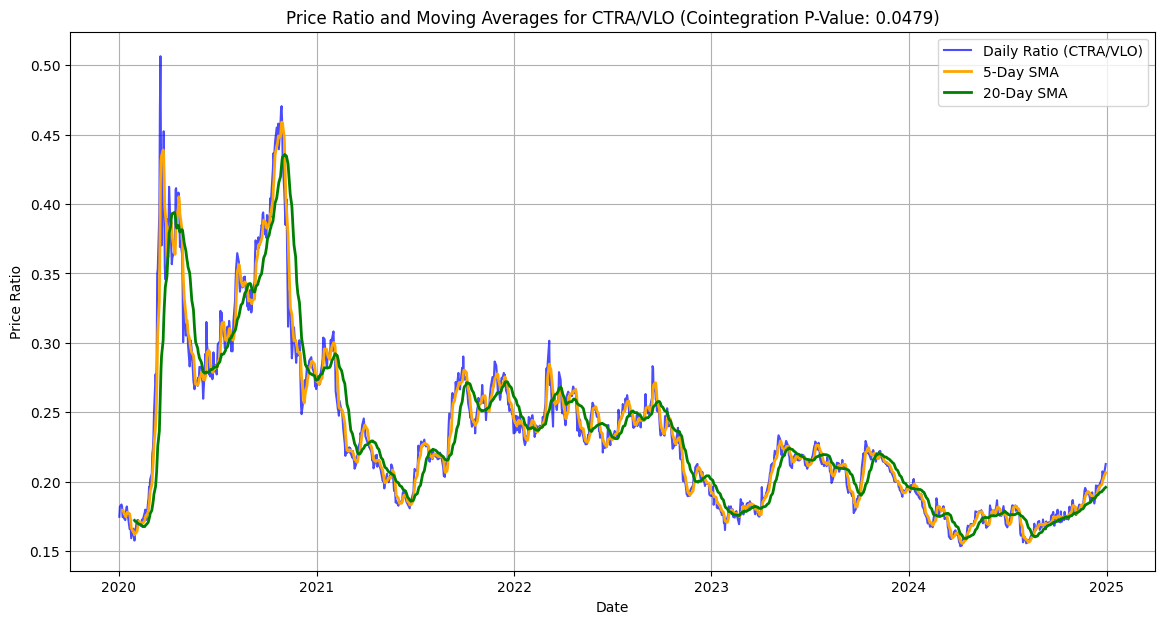

In [ ]:
import matplotlib.pyplot as plt

print("\nCalculating and Plotting Moving Average Ratios for Cointegrated Pairs...")

if cointegrated_pairs_df.empty:
    print("No cointegrated pairs to plot moving average ratios for.")
else:
    for index, row in cointegrated_pairs_df.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']
        p_value = row['Cointegration_P_Value']

        # 1. Calculate the daily price ratio
        price_ratio = (prices[stock1] / prices[stock2]).dropna()

        if price_ratio.empty:
            print(f"Skipping plotting for pair {stock1}/{stock2} due to empty price ratio after dropping NaNs.")
            continue

        # 2. Calculate the 5-day Simple Moving Average (SMA)
        sma_5 = price_ratio.rolling(window=5).mean()

        # 3. Calculate the 20-day Simple Moving Average (SMA)
        sma_20 = price_ratio.rolling(window=20).mean()

        # 4. Create a time-series plot
        plt.figure(figsize=(14, 7))
        plt.plot(price_ratio, label=f'Daily Ratio ({stock1}/{stock2})', color='blue', alpha=0.7)
        plt.plot(sma_5, label='5-Day SMA', color='orange', linewidth=2)
        plt.plot(sma_20, label='20-Day SMA', color='green', linewidth=2)

        # 5. Add clear title, labels, and legend
        plt.title(f'Price Ratio and Moving Averages for {stock1}/{stock2} (Cointegration P-Value: {p_value:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Price Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Rolling z-score for price-ratios


Calculating and Plotting Rolling Z-Scores for Ratios of Cointegrated Pairs...


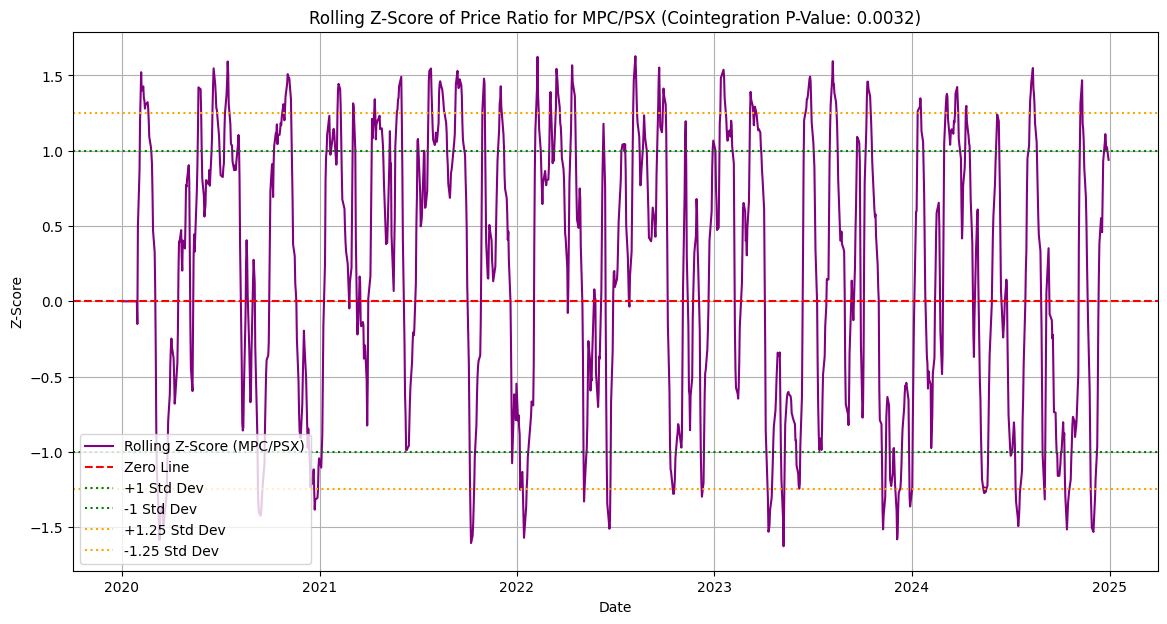

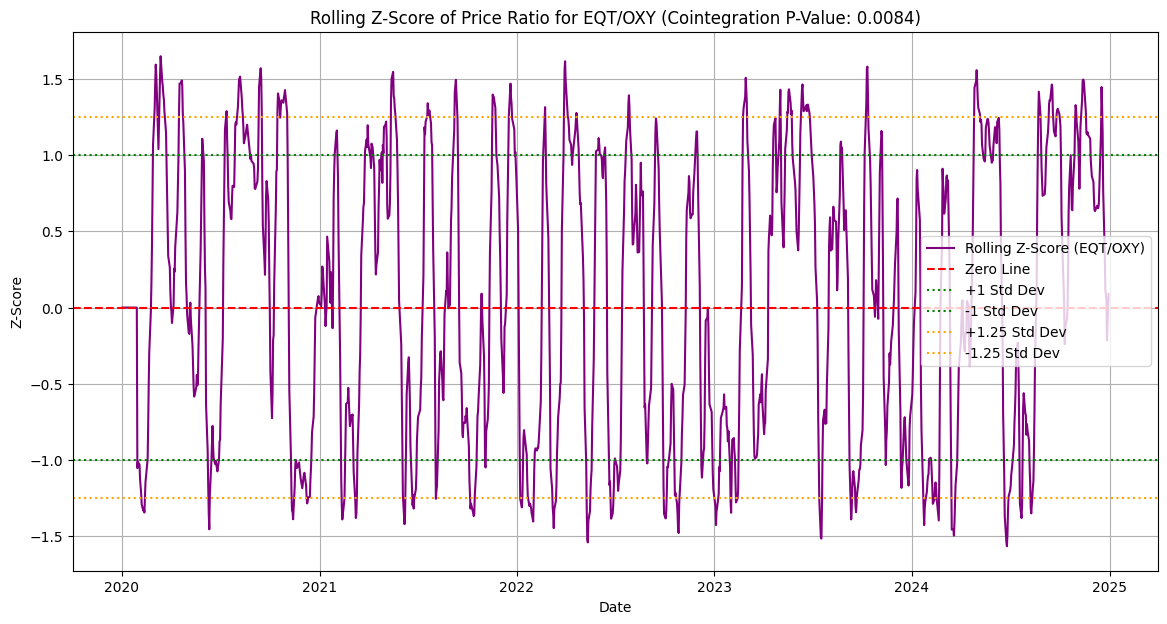

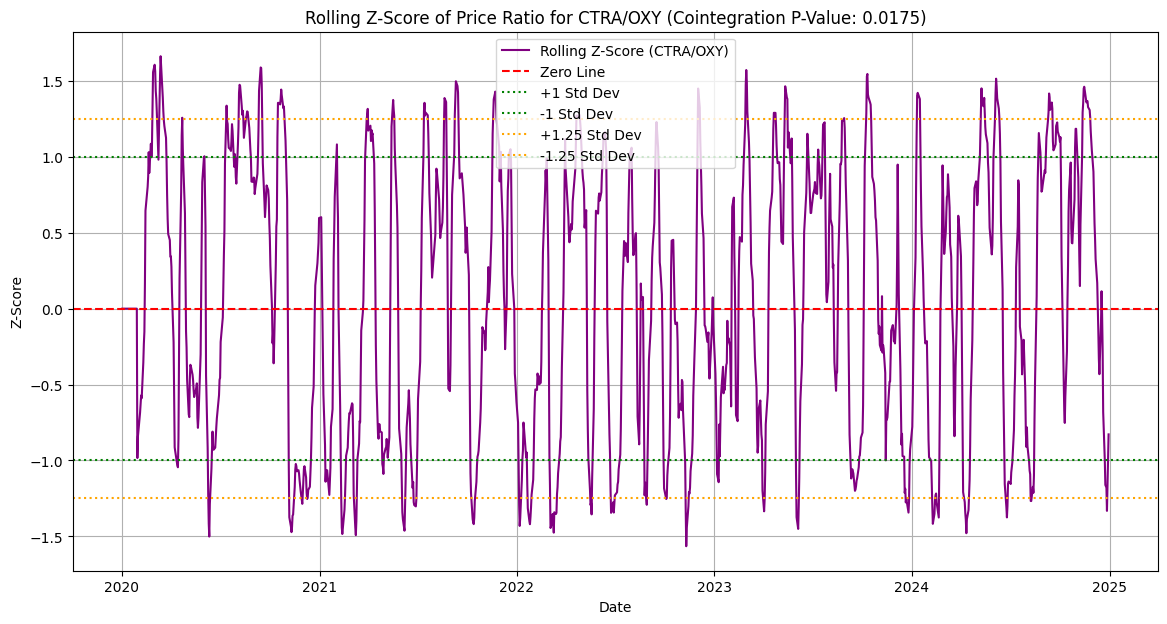

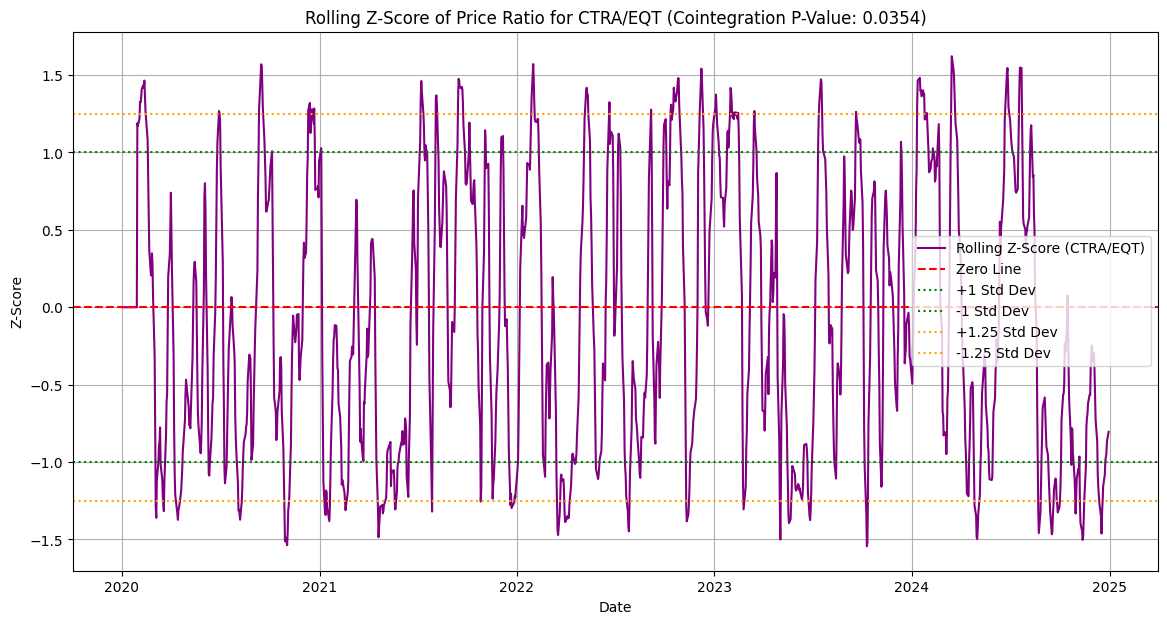

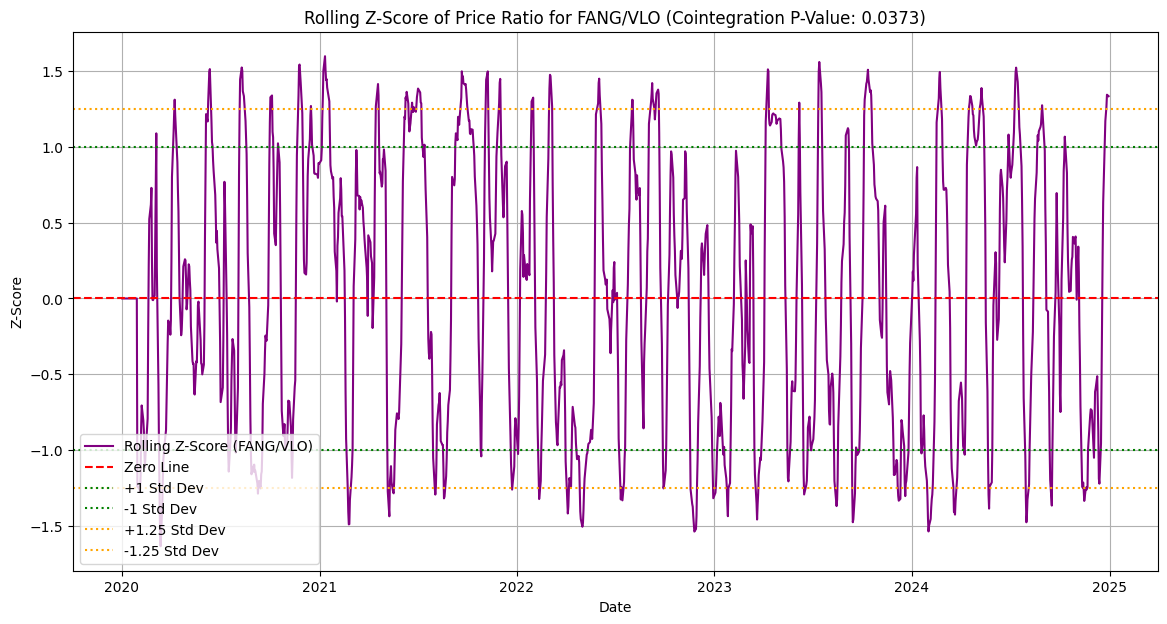

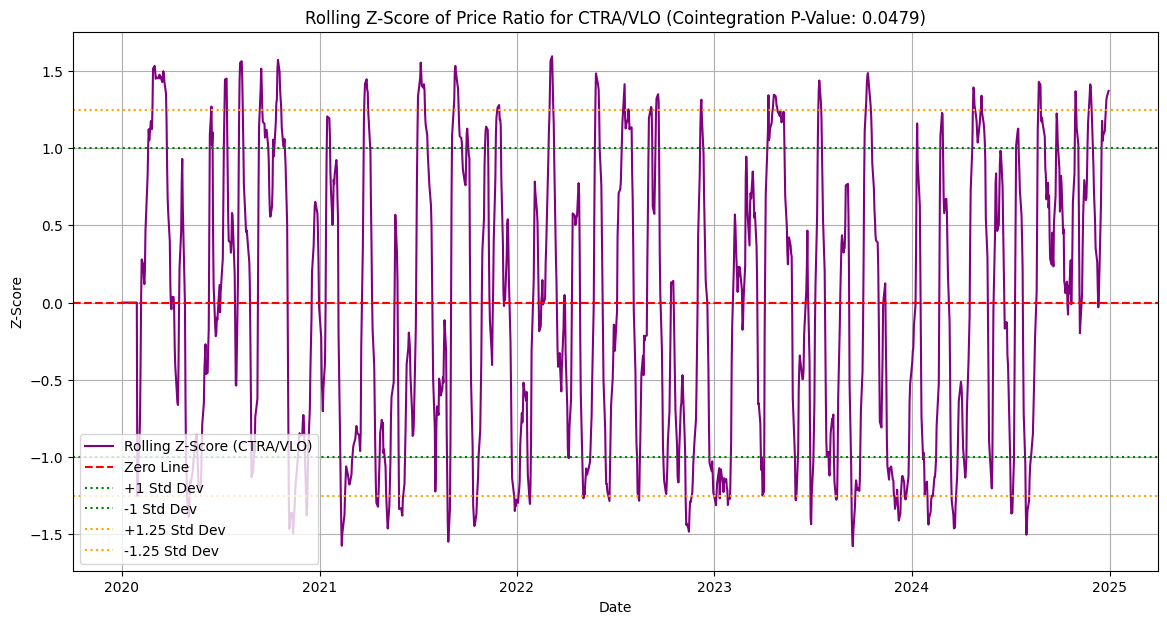

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("\nCalculating and Plotting Rolling Z-Scores for Ratios of Cointegrated Pairs...")

if cointegrated_pairs_df.empty:
    print("No cointegrated pairs to calculate rolling Z-scores for.")
else:
    for index, row in cointegrated_pairs_df.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']
        p_value = row['Cointegration_P_Value']

        # 1. Calculate the daily price ratio
        price_ratio = (prices[stock1] / prices[stock2]).dropna()

        if price_ratio.empty:
            print(f"Skipping plotting for pair {stock1}/{stock2} due to empty price ratio after dropping NaNs.")
            continue

        # 2. Calculate the 5-day Simple Moving Average (SMA)
        sma_5 = price_ratio.rolling(window=5).mean()

        # 3. Calculate the 20-day Simple Moving Average (SMA)
        sma_20 = price_ratio.rolling(window=20).mean()

        # 4. Calculate the 20-day rolling standard deviation
        rolling_std_20 = price_ratio.rolling(window=20).std()

        # 5. Compute the Z-score: (5-day SMA - 20-day SMA) / 20-day rolling standard deviation
        # Handle potential division by zero by replacing NaNs or infinite values with 0
        z_score = (sma_5 - sma_20) / rolling_std_20
        z_score = z_score.replace([np.inf, -np.inf], np.nan).fillna(0)

        # 6. Create a time-series plot for the calculated Z-score
        plt.figure(figsize=(14, 7))
        plt.plot(z_score, label=f'Rolling Z-Score ({stock1}/{stock2})', color='purple')

        # 7. Add clear title, labels, and legend
        plt.title(f'Rolling Z-Score of Price Ratio for {stock1}/{stock2} (Cointegration P-Value: {p_value:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Z-Score')
        plt.axhline(0, color='red', linestyle='--', label='Zero Line')
        plt.axhline(1, color='green', linestyle=':', label='+1 Std Dev')
        plt.axhline(-1, color='green', linestyle=':', label='-1 Std Dev')
        plt.axhline(1.25, color='orange', linestyle=':', label='+1.25 Std Dev')
        plt.axhline(-1.25, color='orange', linestyle=':', label='-1.25 Std Dev')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Trading Signals


Plotting Trading Signals for Cointegrated Pairs based on Z-Score...


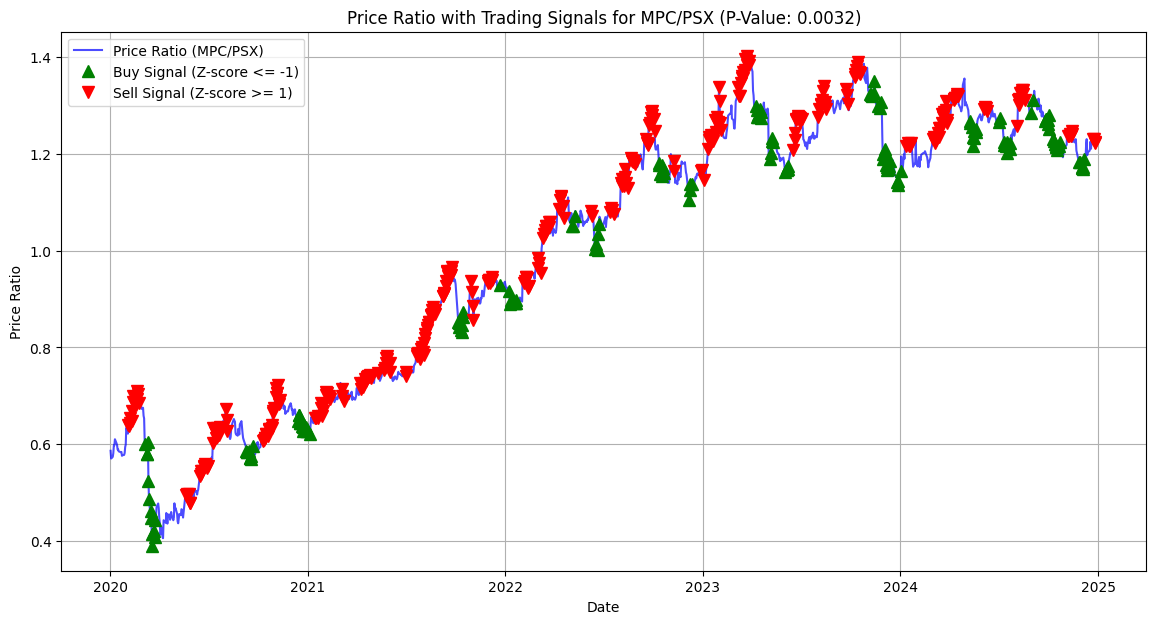

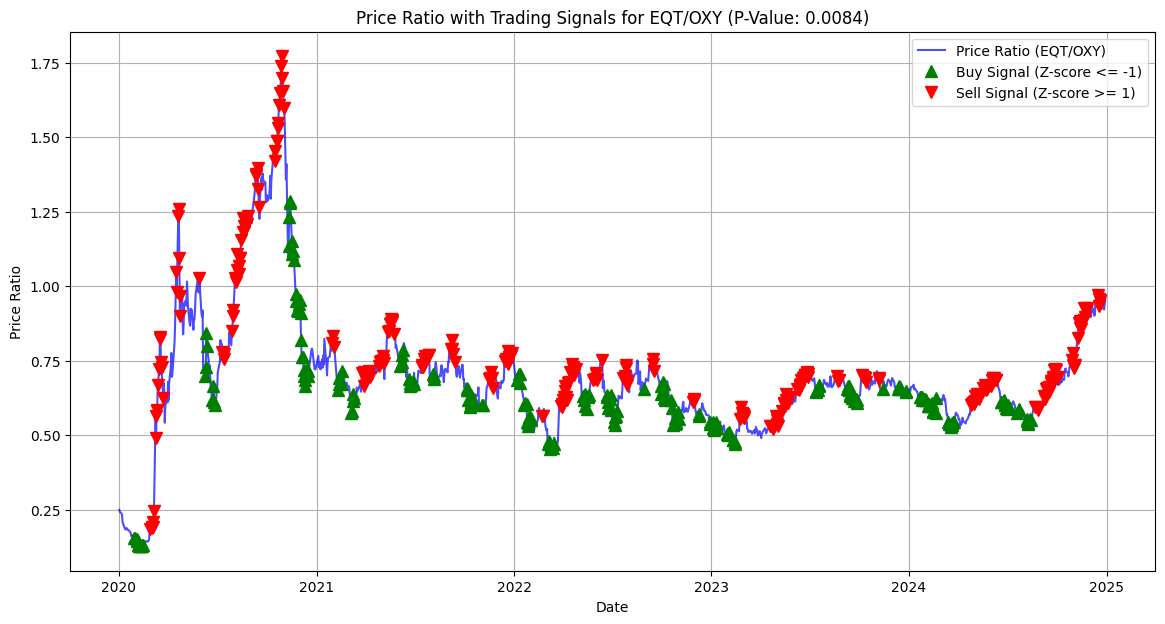

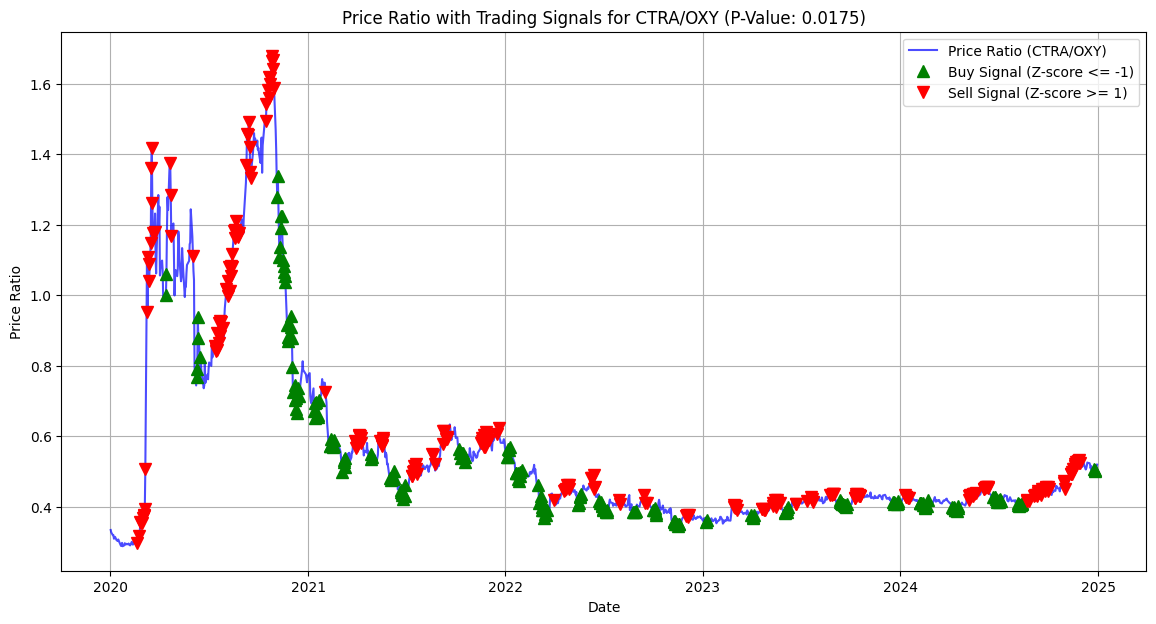

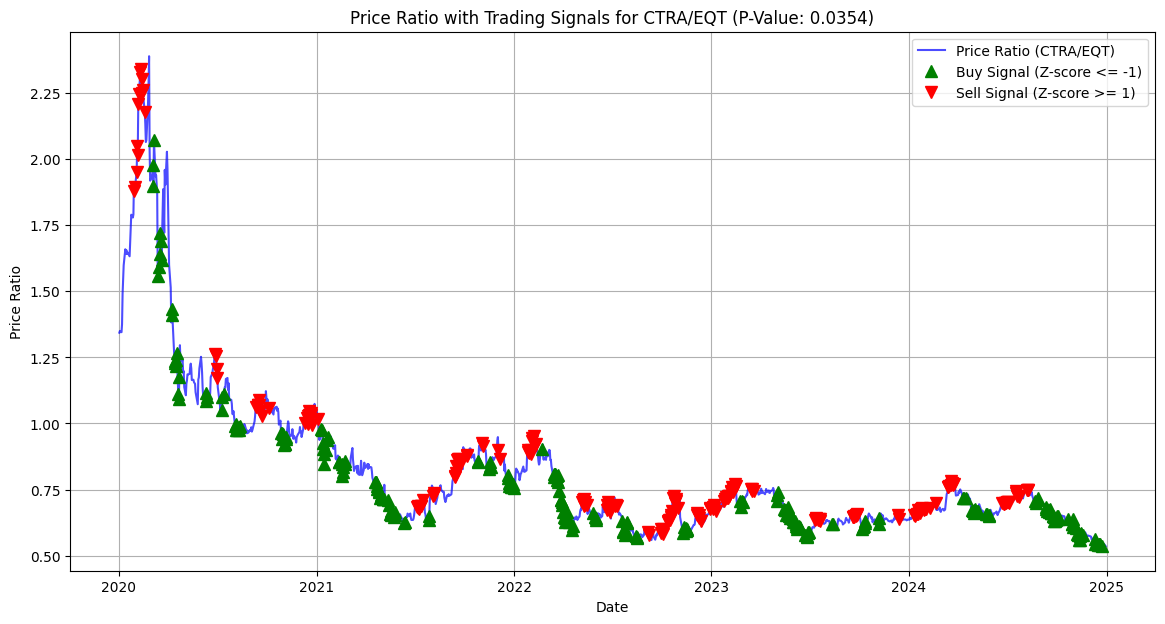

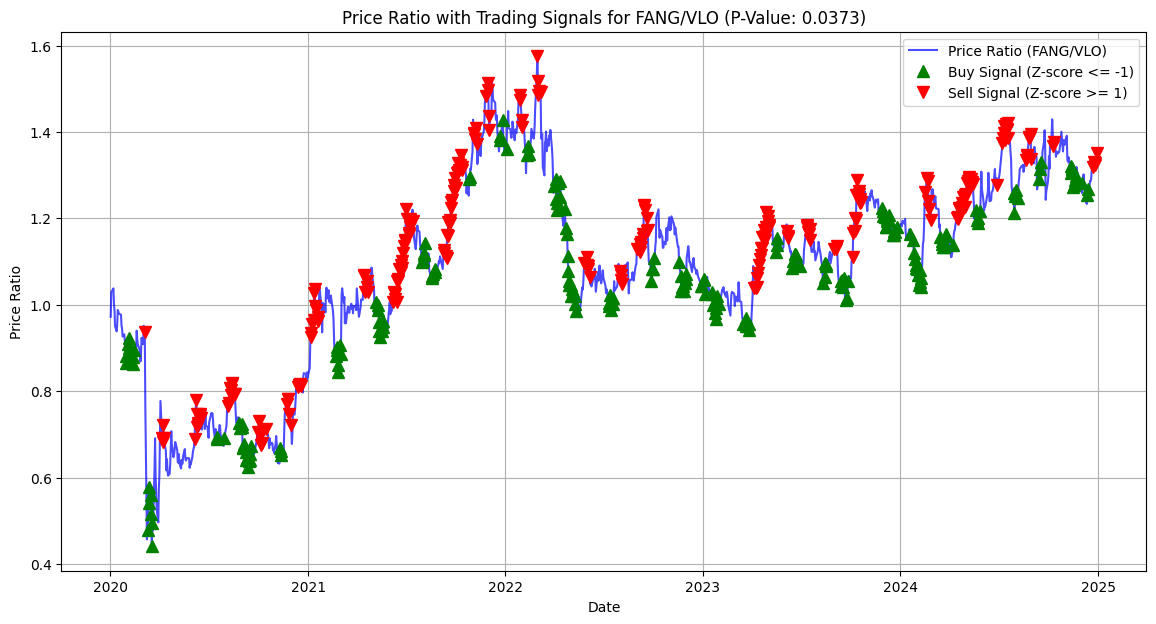

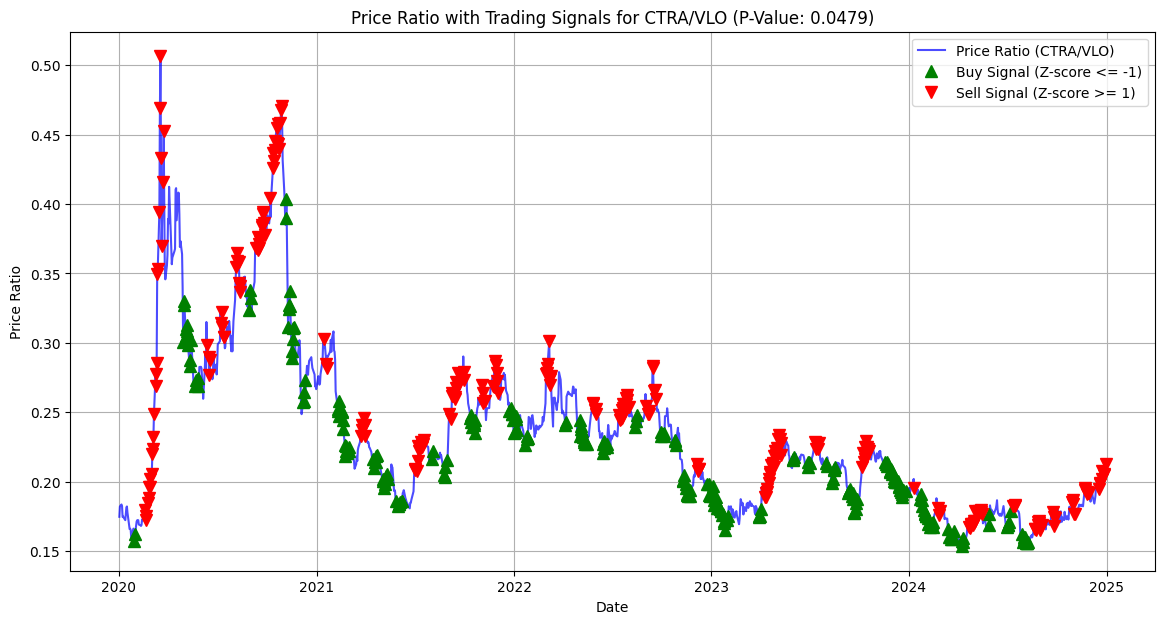

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("\nPlotting Trading Signals for Cointegrated Pairs based on Z-Score...")

if cointegrated_pairs_df.empty:
    print("No cointegrated pairs to plot signals for.")
else:
    for index, row in cointegrated_pairs_df.iterrows():
        stock1 = row['Stock1']
        stock2 = row['Stock2']
        p_value = row['Cointegration_P_Value']

        # 1. Calculate the daily price ratio
        price_ratio = (prices[stock1] / prices[stock2]).dropna()

        if price_ratio.empty:
            print(f"Skipping plotting signals for pair {stock1}/{stock2} due to empty price ratio after dropping NaNs.")
            continue

        # 2. Calculate the 5-day Simple Moving Average (SMA)
        sma_5 = price_ratio.rolling(window=5).mean()

        # 3. Calculate the 20-day Simple Moving Average (SMA)
        sma_20 = price_ratio.rolling(window=20).mean()

        # 4. Calculate the 20-day rolling standard deviation
        rolling_std_20 = price_ratio.rolling(window=20).std()

        # 5. Compute the Z-score: (5-day SMA - 20-day SMA) / 20-day rolling standard deviation
        z_score = (sma_5 - sma_20) / rolling_std_20
        z_score = z_score.replace([np.inf, -np.inf], np.nan).fillna(0)

        # 6. Generate Buy and Sell signals
        # Buy when Z-score goes below -1 (or other chosen threshold)
        # Sell when Z-score goes above 1 (or other chosen threshold)
        buy_signals = price_ratio.copy()
        sell_signals = price_ratio.copy()

        buy_signals[z_score > -1] = np.nan  # Only keep values where Z-score is <= -1
        sell_signals[z_score < 1] = np.nan   # Only keep values where Z-score is >= 1

        # 7. Plot the price ratio and signals
        plt.figure(figsize=(14, 7))
        plt.plot(price_ratio, label=f'Price Ratio ({stock1}/{stock2})', color='blue', alpha=0.7)
        plt.plot(buy_signals, color='green', linestyle='None', marker='^', markersize=8, label='Buy Signal (Z-score <= -1)')
        plt.plot(sell_signals, color='red', linestyle='None', marker='v', markersize=8, label='Sell Signal (Z-score >= 1)')

        plt.title(f'Price Ratio with Trading Signals for {stock1}/{stock2} (P-Value: {p_value:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Price Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()

## Part II: Backtesting


#### Backtesting ->